In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
# %matplotlib inline

In [2]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor

### Установлю все необходимые библиотеки

In [3]:
# !pip install xgboost
# !pip install catboost
# !pip install feature_engine


In [4]:
RANDOM_SEED = 42

In [5]:
def outliers(df, col):
    '''Поиск выбросов по формуле +/- полтора межквартильного размаха'''
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    left_line = perc25 - 1.5*IQR
    left_count = df[col][df[col] < left_line].count()
    right_line = perc75 + 1.5*IQR
    right_count = df[col][df[col] > right_line].count()
    #print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
 
    return left_line, left_count, right_line, right_count

In [6]:
def normalize_feature(df, columns):
    '''
        Нормолизация числовых признаков
    '''
    a_features = df[columns].values
    norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
    df.loc[:, columns] = norm_features

In [7]:
def encode_cat(X, y, test_df, variables_rare, cat_features):
    '''кодирование категориальных переменных, переменные в которых много категорий и они не совпадают
       в тестовом и обучающем датасетах обрабатываются предварительно отсекая малочисленные категории,
       после этого кодирую значения методом Ordered Integer Encoding
    '''

    rare_encoder = RareLabelEncoder(
        tol=0.01,  # minimal percentage to be considered non-rare

        variables=variables_rare # variables to re-group
    )

    rare_encoder.fit(X)
    X = rare_encoder.transform(X)
    test_df = rare_encoder.transform(test_df)

    ordinal_enc = OrdinalEncoder(
        encoding_method='ordered',
        variables=cat_features)

    ordinal_enc.fit(X, y)
    X = ordinal_enc.transform(X)
    test_df = ordinal_enc.transform(test_df)
    
    return X, test_df

### Загружаю данные

In [8]:
train = pd.read_csv('train2.csv', low_memory=False)
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45191 entries, 0 to 45196
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              45191 non-null  object 
 1   brand                 45191 non-null  object 
 2   car_url               45191 non-null  object 
 3   color                 45191 non-null  object 
 4   complectation_dict    45191 non-null  object 
 5   description           45191 non-null  object 
 6   engineDisplacement    45191 non-null  object 
 7   enginePower           45191 non-null  object 
 8   equipment_dict        45191 non-null  object 
 9   fuelType              45191 non-null  object 
 10  image                 45189 non-null  object 
 11  mileage               45191 non-null  float64
 12  modelDate             45191 non-null  float64
 13  model_info            45191 non-null  object 
 14  model_name            45191 non-null  object 
 15  name               

## Предобработка данных

In [11]:
train.isna().mean()

bodyType                0.000000
brand                   0.000000
car_url                 0.000000
color                   0.000000
complectation_dict      0.000000
description             0.000000
engineDisplacement      0.000000
enginePower             0.000000
equipment_dict          0.000000
fuelType                0.000000
image                   0.000044
mileage                 0.000000
modelDate               0.000000
model_info              0.000000
model_name              0.000000
name                    0.000000
numberOfDoors           0.000000
parsing_unixtime        0.000000
priceCurrency           0.000000
productionDate          0.000000
sell_id                 0.000000
super_gen               0.000000
vehicleConfiguration    0.000000
vehicleTransmission     0.000000
vendor                  0.000000
Владельцы               0.000000
Владение                0.768051
ПТС                     0.000000
Привод                  0.000000
Руль                    0.000000
Состояние 

In [12]:
test.isna().mean()

bodyType                0.000000
brand                   0.000000
car_url                 0.000000
color                   0.000000
complectation_dict      0.814969
description             0.000000
engineDisplacement      0.000000
enginePower             0.000000
equipment_dict          0.288185
fuelType                0.000000
image                   0.000000
mileage                 0.000000
modelDate               0.000000
model_info              0.000000
model_name              0.000000
name                    0.000000
numberOfDoors           0.000000
parsing_unixtime        0.000000
priceCurrency           0.000000
productionDate          0.000000
sell_id                 0.000000
super_gen               0.000000
vehicleConfiguration    0.000000
vehicleTransmission     0.000000
vendor                  0.000000
Владельцы               0.000000
Владение                0.654183
ПТС                     0.000029
Привод                  0.000000
Руль                    0.000000
Состояние 

+ можно удалить колонки Таможня и Состояние так как они содержат только одно значение, 
+ Image можно заменить на бинарный признак уникальная картинка или нет
+ vendor из трейна удалит AMERICAN так как в тесте нет объектов с таким значением


In [13]:
train.vendor.unique()

array(['EUROPEAN', 'AMERICAN', 'JAPANESE'], dtype=object)

In [14]:
train['Состояние'].unique()

array(['Не требует ремонта', 'Битый / не на ходу'], dtype=object)

In [15]:
# train[~train['Состояние'].str.contains('Битый / не на ходу')]
train = train.drop(train[train['Состояние'] == 'Битый / не на ходу'].index)

In [16]:
train = train.drop(train[train['vendor'] == 'AMERICAN'].index)

In [17]:
train = train.drop(['Таможня', 'Состояние'], axis=1)
test = test.drop(['Таможня', 'Состояние'], axis=1)

In [18]:
test.model_name.nunique(), train.model_name.nunique()

(544, 552)

наборы моделей не совпадают, возможно за год после сбора тестовой выборки вышли новые модели, эту информацию учту при кодировании категориальных признаков

In [19]:
result=list(set(train.model_name.unique()) ^ set(test.model_name.unique()))
len(result)

152

In [20]:
len(result), 552-544

(152, 8)

В колонке bodyType тоже есть различия которые в дальнейшем могут помешать созданию модели

In [21]:
test.bodyType.unique()

array(['лифтбек', 'внедорожник 5 дв.', 'хэтчбек 5 дв.', 'седан',
       'компактвэн', 'универсал 5 дв.', 'пикап одинарная кабина',
       'хэтчбек 3 дв.', 'купе', 'кабриолет', 'минивэн',
       'пикап двойная кабина', 'внедорожник 3 дв.', 'родстер', 'микровэн',
       'седан 2 дв.', 'купе-хардтоп', 'фастбек', 'тарга',
       'внедорожник открытый', 'лимузин', 'пикап полуторная кабина',
       'седан-хардтоп', 'фургон'], dtype=object)

In [22]:
train.bodyType.unique()

array(['внедорожник 5 дв.', 'минивэн', 'седан', 'хэтчбек 3 дв.',
       'универсал 5 дв.', 'лифтбек', 'компактвэн', 'хэтчбек 5 дв.',
       'купе', 'родстер', 'кабриолет', 'седан 2 дв.', 'внедорожник 3 дв.',
       'тарга', 'купе-хардтоп', 'лимузин', 'микровэн', 'седан-хардтоп',
       'фургон', 'пикап двойная кабина', 'пикап одинарная кабина',
       'пикап полуторная кабина', 'фастбек', 'универсал 3 дв.'],
      dtype=object)

In [23]:
list(set(train.bodyType.unique()) ^ set(test.bodyType.unique()))

['универсал 3 дв.', 'внедорожник открытый']

посмотрю на открытые внедорожники и заменю название взависимости от кол-ва дверей  
так как унивирсалы в основном с 5 дв, то уберу кол-во дверей и оставлю просто "универсал"

In [24]:
for car_u in test[test.bodyType == 'внедорожник_открытый']['car_url']:
    print(car_u)

In [25]:
test.loc[test.car_url == 'https://auto.ru/cars/used/sale/mercedes/g_klasse/1099789852-e52268b0/', 'bodyType']= 'внедорожник 3 дв.'
test.loc[test.car_url == 'https://auto.ru/cars/used/sale/mercedes/g_klasse/1099097060-e27d87c9/', 'bodyType'] = 'внедорожник 3 дв.'
test.loc[test.car_url == 'https://auto.ru/cars/used/sale/toyota/rav_4/1101360940-5481aa6f/', 'bodyType'] = 'внедорожник 5 дв.'

In [26]:
test['bodyType'] = test.bodyType.str.replace('универсал_3_дв.', 'универсал')
test['bodyType'] = test.bodyType.str.replace('универсал_5_дв.', 'универсал')
train['bodyType'] = train['bodyType'].str.replace('универсал_3_дв.', 'универсал')
train['bodyType'] = train['bodyType'].str.replace('универсал_5_дв.', 'универсал')

### Пропуски:
+ bodyType - восстановлю по названию модели (для начала попробовать допарстить данные)
+ complectation_dict - очень много пропущенных знач. в трейне и тесте, попробую удалить
+ equipment_dict - тоже самое, удалю признак
+ Владение - пока удалю 
+ Картинки удалить так как в тесте все с картинками

In [27]:
train[train['bodyType'].isna()].head() # https://auto.ru/cars/used/sale/honda/civic/1097454742-c7416dcb/ странный авто возм удалить

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,price


In [28]:
train[train['image'].isna()]['car_url'].value_counts()

https://auto.ru/cars/used/sale/infiniti/qx80/1103706275-a31b4b65/        1
https://auto.ru/cars/used/sale/mercedes/g_klasse/1103619516-91afaa58/    1
Name: car_url, dtype: int64

In [29]:
# links = train.iloc[103:200,2]
# links.apply(lambda x: print(x))

train.iloc[30661, 10]

'https://autoru.naydex.net/j1vWw7845/f892baZj9/sLb6WmHz4KC5GYW9ofLUecWlAySQz9oVDeLVP9ggJ8yBtXl3LB1qUaz4MNObD8BmA2KSO-loSYhEjd-P_lmx6LT_0n4VkoDt_VDEueWLgGzJ_CpFlZKHNFSTkC4YwLcZPU2R77TJm93wkC3T8ibF16sn61ro8MRFrdwPG8aZPKA#DSD'

In [30]:
# img for 30661 - https://avatars.mds.yandex.net/get-autoru-vos/3710589/27ee34bf31b2f6f6ff8ed0c70a464d1c/1200x900n

In [31]:
# 29729 - Не растаможен
# 31182 - Не растаможен
# 35129 - Не растаможен
# 31697 - битый / не на ходу
# 32314 -  битый / не на ходу
# train.to_csv('train.csv', index_label = False)

In [32]:
# train = train.drop([29729, 31182, 35129, 31697, 32314, 32130], axis='index')

In [33]:
train.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,price
0,внедорожник 5 дв.,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/tigu...,белый,{'id': '0'},КЛЮЧАВТО | автомобили с пробегом — направление...,2.0 LTR,170 N12,"{'cruise-control': True, 'airbag-driver': True...",бензин,...,"{'id': '7339785', 'name': 'I Рестайлинг', 'ru_...",ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,2 владельца,NaN,Оригинал,полный,Левый,1099000.0
1,минивэн,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/mult...,коричневый,{'id': '0'},Авто в идеальном состоянии. Немецкая сборка. М...,2.0 LTR,180 N12,"{'cruise-control': True, 'esp': True, 'airbag-...",дизель,...,"{'id': '8237731', 'name': 'T5 Рестайлинг', 'ru...",MINIVAN ROBOT 2.0,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,полный,Левый,1895000.0
2,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/pass...,чёрный,{'id': '0'},Артикул: 26853\n\nПРИ ПОКУПКЕ АВТОМОБИЛЯ В КРЕ...,1.8 LTR,152 N12,"{'asr': True, 'tinted-glass': True, 'esp': Tru...",бензин,...,"{'id': '7813123', 'name': 'I Рестайлинг', 'ru_...",SEDAN ROBOT 1.8,роботизированная,EUROPEAN,2 владельца,NaN,Оригинал,передний,Левый,885000.0
3,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/pass...,серый,{'id': '0'},КЛЮЧАВТО | автомобили с пробегом — направление...,1.4 LTR,150 N12,"{'cruise-control': True, 'engine-proof': True,...",бензин,...,"{'id': '20232305', 'name': 'B8', 'year_from': ...",SEDAN ROBOT 1.4,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,2099000.0
4,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/polo...,белый,{'id': '0'},СКИДКА НА АВТОМОБИЛЬ СЕГОДНЯ ДО 21:00 !!!\nАвт...,1.6 LTR,90 N12,{},бензин,...,"{'id': '20113124', 'name': 'V Рестайлинг', 'ru...",SEDAN MECHANICAL 1.6,механическая,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,649990.0


### Пропуски в категориальных данных заменю на no_info

In [34]:
# for col in na_cols:
#     train[col].apply(lambda x: print(type(x)))

In [35]:
train['Владение'].fillna('no_info', inplace=True)
test['Владение'].fillna('no_info', inplace=True)

In [36]:
test['complectation_dict'].fillna('no_info', inplace=True)
test['equipment_dict'].fillna('no_info', inplace=True)

In [37]:
train['complectation_dict'] = train['complectation_dict'].apply(lambda x: 'no_info' if x == "{'id': '0'}" else x)
train['equipment_dict'] = train['equipment_dict'].apply(lambda x: 'no_info' if x == "{}" else x)

In [38]:
train.isna().mean()

bodyType                0.000000
brand                   0.000000
car_url                 0.000000
color                   0.000000
complectation_dict      0.000000
description             0.000000
engineDisplacement      0.000000
enginePower             0.000000
equipment_dict          0.000000
fuelType                0.000000
image                   0.000044
mileage                 0.000000
modelDate               0.000000
model_info              0.000000
model_name              0.000000
name                    0.000000
numberOfDoors           0.000000
parsing_unixtime        0.000000
priceCurrency           0.000000
productionDate          0.000000
sell_id                 0.000000
super_gen               0.000000
vehicleConfiguration    0.000000
vehicleTransmission     0.000000
vendor                  0.000000
Владельцы               0.000000
Владение                0.000000
ПТС                     0.000000
Привод                  0.000000
Руль                    0.000000
price     

In [39]:
test.isna().mean()

bodyType                0.000000
brand                   0.000000
car_url                 0.000000
color                   0.000000
complectation_dict      0.000000
description             0.000000
engineDisplacement      0.000000
enginePower             0.000000
equipment_dict          0.000000
fuelType                0.000000
image                   0.000000
mileage                 0.000000
modelDate               0.000000
model_info              0.000000
model_name              0.000000
name                    0.000000
numberOfDoors           0.000000
parsing_unixtime        0.000000
priceCurrency           0.000000
productionDate          0.000000
sell_id                 0.000000
super_gen               0.000000
vehicleConfiguration    0.000000
vehicleTransmission     0.000000
vendor                  0.000000
Владельцы               0.000000
Владение                0.000000
ПТС                     0.000029
Привод                  0.000000
Руль                    0.000000
dtype: flo

In [40]:
test[test['ПТС'].isna()].head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль
10412,седан,BMW,https://auto.ru/cars/used/sale/bmw/3er/3350400...,синий,no_info,"Сделано большое Т.О. Фильтра масляный, воздушн...",2.5 LTR,170 N12,no_info,бензин,...,33504008,"{""id"":""6329491"",""name"":""323"",""nameplate"":""323i...",SEDAN AUTOMATIC 2.5,автоматическая,EUROPEAN,3 или более,no_info,NaN,задний,Левый


In [41]:
test['ПТС'].value_counts()

Оригинал    30098
Дубликат     4587
Name: ПТС, dtype: int64

In [42]:
test['ПТС'].fillna(test['ПТС'].mode()[0], inplace=True) 

In [43]:
test['ПТС'].isna().sum()

0

In [44]:
train['image'].fillna(0, inplace=True)

In [45]:
sum(test.isna().sum()), sum(train.isna().sum())

(0, 0)

## EDA

In [46]:
train.describe(include='object')

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,priceCurrency,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль
count,45188,45188,45188,45188,45188,45188,45188,45188,45188,45188,...,45188,45188,45188,45188,45188,45188,45188,45188,45188,45188
unique,24,12,36632,16,2840,33324,53,315,26352,5,...,1,1453,602,4,2,3,254,2,3,2
top,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/used/sale/toyota/alphard/...,чёрный,no_info,Мы предлагаем Вам сформированные индивидуальны...,2.0 LTR,249 N12,no_info,бензин,...,RUB,"{'id': '20113124', 'name': 'V Рестайлинг', 'ru...",ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,EUROPEAN,3 или более,no_info,Оригинал,полный,Левый
freq,19525,4772,96,14529,35919,360,10343,3300,10015,36832,...,45188,533,3322,26560,24140,20086,34706,38296,22465,42370


## Целевая переменная - price

In [47]:
pd.set_option('float_format', '{:f}'.format)
train['price'].describe()

count      45188.000000
mean     1555550.188015
std      1746000.373447
min        23000.000000
25%       560000.000000
50%      1080000.000000
75%      1979000.000000
max     55000000.000000
Name: price, dtype: float64

отрицательных значений нет, уже хорошо<br>
очень большой размах

<AxesSubplot:xlabel='price', ylabel='Density'>

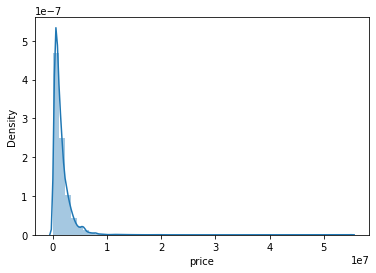

In [48]:
sns.distplot(train['price'])

Расперделение асимметричное 

In [49]:
print(f"Асимметрия: {train['price'].skew()}")
print(f"Эксцесс: {train['price'].kurt()}")

Асимметрия: 7.737651827564784
Эксцесс: 167.6510734761553


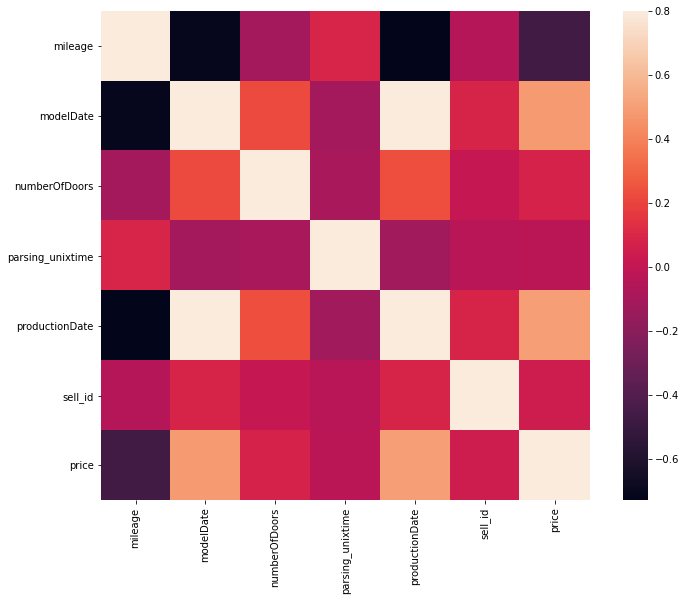

In [50]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

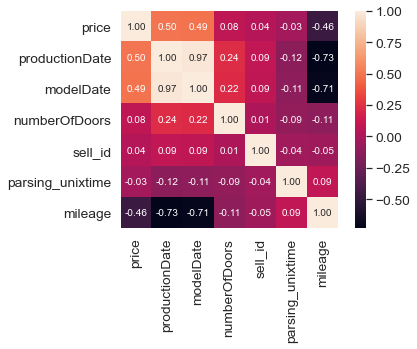

In [51]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()



In [52]:
train.corr()

,mileage,modelDate,numberOfDoors,parsing_unixtime,productionDate,sell_id,price
mileage,1.000000,-0.708551,-0.111621,0.090977,-0.730449,-0.045760,-0.463754
modelDate,-0.708551,1.000000,0.221587,-0.112758,0.974813,0.085091,0.488829
numberOfDoors,-0.111621,0.221587,1.000000,-0.093876,0.235084,0.011161,0.081687
parsing_unixtime,0.090977,-0.112758,-0.093876,1.000000,-0.118789,-0.036395,-0.030284
productionDate,-0.730449,0.974813,0.235084,-0.118789,1.000000,0.087938,0.497197
sell_id,-0.045760,0.085091,0.011161,-0.036395,0.087938,1.000000,0.040873
price,-0.463754,0.488829,0.081687,-0.030284,0.497197,0.040873,1.000000


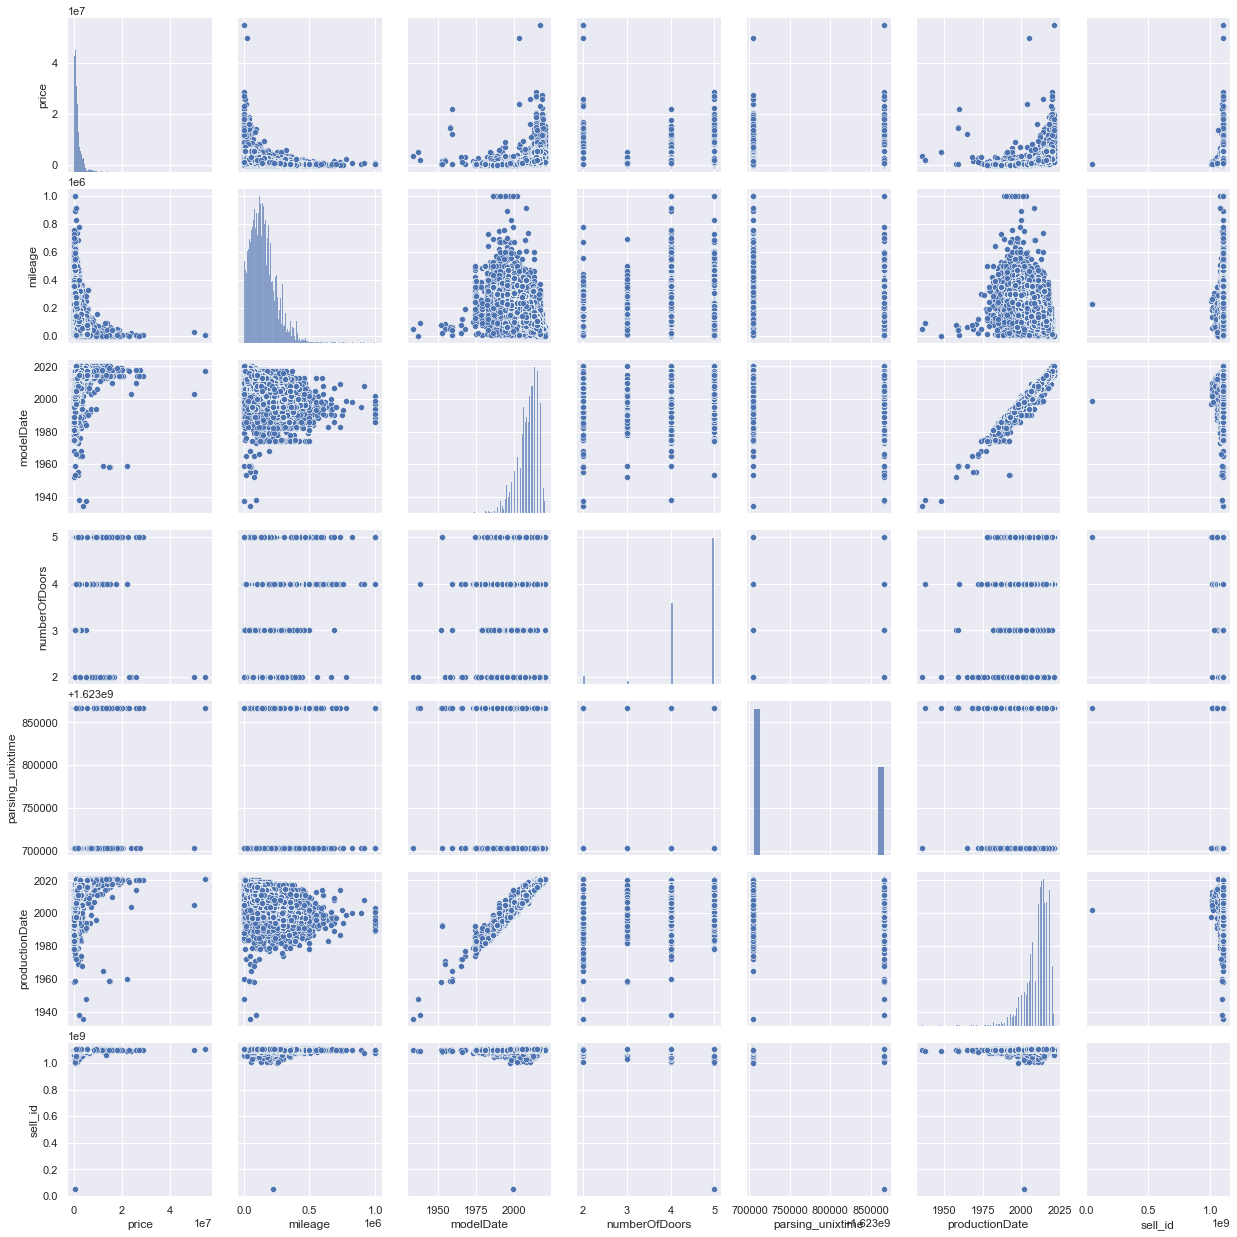

In [53]:
#scatterplot
sns.set()
cols = ['price', 'mileage', 'modelDate', 'numberOfDoors', 'parsing_unixtime', 'productionDate', 'sell_id']
sns.pairplot(train[cols], size = 2.5)
plt.show();

modelDate и productionDate взаимосвязаны, оставлю один из этих принаков

In [54]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45188 entries, 0 to 45196
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              45188 non-null  object 
 1   brand                 45188 non-null  object 
 2   car_url               45188 non-null  object 
 3   color                 45188 non-null  object 
 4   complectation_dict    45188 non-null  object 
 5   description           45188 non-null  object 
 6   engineDisplacement    45188 non-null  object 
 7   enginePower           45188 non-null  object 
 8   equipment_dict        45188 non-null  object 
 9   fuelType              45188 non-null  object 
 10  image                 45188 non-null  object 
 11  mileage               45188 non-null  float64
 12  modelDate             45188 non-null  float64
 13  model_info            45188 non-null  object 
 14  model_name            45188 non-null  object 
 15  name               

### bodyType - тип кузова (categorical)

посмотрим распределение признака

In [55]:
train['bodyType'].value_counts()

внедорожник 5 дв.          19525
седан                      14323
лифтбек                     2826
хэтчбек 5 дв.               2717
универсал 5 дв.             1429
минивэн                     1134
купе                        1017
компактвэн                   542
хэтчбек 3 дв.                468
пикап двойная кабина         420
купе-хардтоп                 267
внедорожник 3 дв.            159
кабриолет                    110
седан-хардтоп                 75
родстер                       57
фургон                        42
пикап одинарная кабина        35
микровэн                      24
пикап полуторная кабина        7
седан 2 дв.                    6
универсал 3 дв.                2
фастбек                        1
лимузин                        1
тарга                          1
Name: bodyType, dtype: int64

In [56]:
train['bodyType'].value_counts(normalize=True)

внедорожник 5 дв.         0.432084
седан                     0.316965
лифтбек                   0.062539
хэтчбек 5 дв.             0.060127
универсал 5 дв.           0.031623
минивэн                   0.025095
купе                      0.022506
компактвэн                0.011994
хэтчбек 3 дв.             0.010357
пикап двойная кабина      0.009295
купе-хардтоп              0.005909
внедорожник 3 дв.         0.003519
кабриолет                 0.002434
седан-хардтоп             0.001660
родстер                   0.001261
фургон                    0.000929
пикап одинарная кабина    0.000775
микровэн                  0.000531
пикап полуторная кабина   0.000155
седан 2 дв.               0.000133
универсал 3 дв.           0.000044
фастбек                   0.000022
лимузин                   0.000022
тарга                     0.000022
Name: bodyType, dtype: float64

In [57]:
test['bodyType'].value_counts(normalize=True)

седан                     0.379029
внедорожник 5 дв.         0.352563
лифтбек                   0.064349
хэтчбек 5 дв.             0.061235
универсал 5 дв.           0.036787
минивэн                   0.028686
купе                      0.023756
компактвэн                0.014098
хэтчбек 3 дв.             0.013983
пикап двойная кабина      0.008072
купе-хардтоп              0.004555
внедорожник 3 дв.         0.003373
родстер                   0.002854
фургон                    0.002797
кабриолет                 0.002595
седан-хардтоп             0.000346
микровэн                  0.000202
седан 2 дв.               0.000173
лимузин                   0.000173
пикап одинарная кабина    0.000144
пикап полуторная кабина   0.000144
тарга                     0.000058
фастбек                   0.000029
Name: bodyType, dtype: float64

распределение в тестовой выборке немного отличается

Посмотрим взаимосвязь с зависимой переменной

In [58]:
pd.options.display.float_format = '{:,.2f} p'.format
train.groupby('bodyType')[['price']].agg(['count', 'mean', 'median', 'std'])

price                                             
                         count           mean         median            std
bodyType                                                                   
внедорожник 3 дв.          159   443,057.68 p   290,000.00 p   467,935.83 p
внедорожник 5 дв.        19525 2,095,385.83 p 1,630,000.00 p 1,714,467.78 p
кабриолет                  110 1,721,787.25 p   775,000.00 p 3,141,701.10 p
компактвэн                 542   527,790.24 p   441,000.00 p   326,480.48 p
купе                      1017 2,593,473.72 p 1,500,000.00 p 5,127,753.16 p
купе-хардтоп               267 1,296,332.70 p 1,000,000.00 p   521,538.98 p
лимузин                      1 5,999,999.00 p 5,999,999.00 p          nan p
лифтбек                   2826 1,137,757.89 p   801,500.00 p 1,230,831.49 p
микровэн                    24   351,708.33 p   300,000.00 p   190,761.97 p
минивэн                   1134 1,973,113.17 p 1,290,000.00 p 2,533,666.24 p
пикап двойная кабина       420 1,850,602.41 p 1,375,000.00 p 1,080,239.33 p
пикап одинарная кабина      35 2,219,246.57 p 2,505,000.00 p   571,952.70 p
пикап полуторная кабина      7   679,571.43 p   680,000.00 p   129,870.26 p
родстер                     57 3,199,097.25 p 1,950,000.00 p 4,167,764.48 p
седан                    14323 1,117,299.92 p   725,000.00 p 1,250,719.68 p
седан 2 дв.                  6 1,195,000.00 p   492,500.00 p 1,898,778.55 p
седан-хардтоп               75    59,573.33 p    55,000.00 p    22,565.32 p
тарга                        1    47,000.00 p    47,000.00 p          nan p
универсал 3 дв.              2   255,081.00 p   255,081.00 p   148,606.98 p
универсал 5 дв.           1429   901,797.69 p   579,000.00 p   941,132.13 p
фастбек                      1   749,000.00 p   749,000.00 p          nan p
фургон                      42   805,745.24 p   590,000.00 p   542,505.23 p
хэтчбек 3 дв.              468   422,575.60 p   378,500.00 p   361,059.89 p
хэтчбек 5 дв.             2717   664,192.51 p   478,600.00 p   532,658.26 p

In [59]:
train[train['bodyType'] == 'кабриолет']['price'].agg(['min', 'max'])

min      505,000.00 p
max   23,100,000.00 p
Name: price, dtype: float64

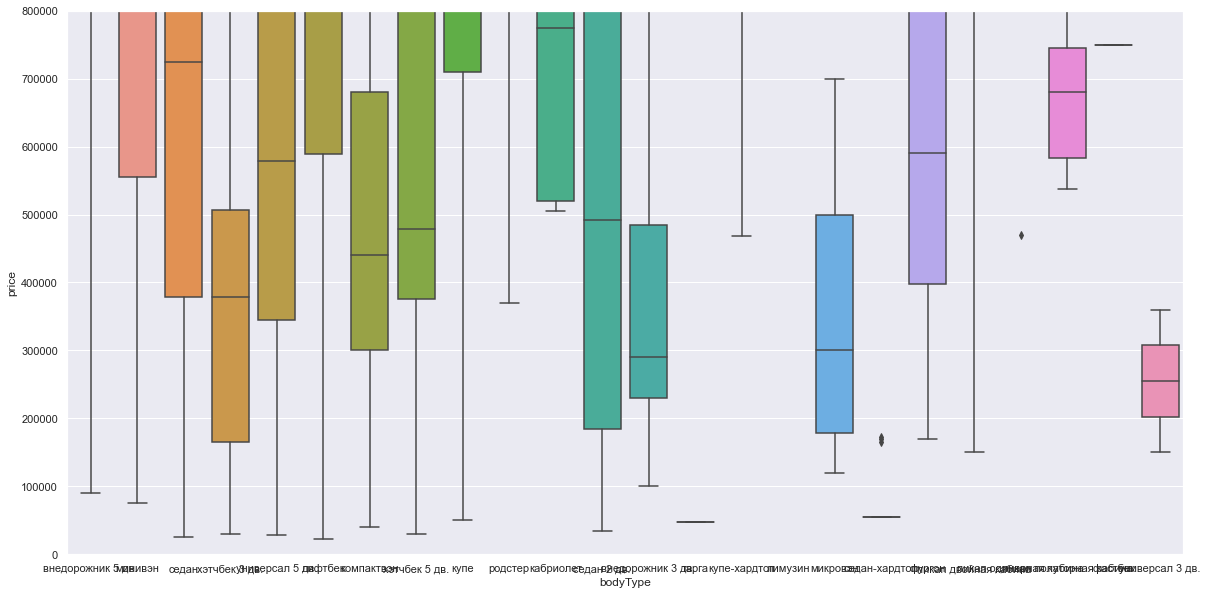

In [60]:
#box plot overallqual/saleprice
var = 'bodyType'
data = pd.concat([train['price'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=800000);

У каждого типа кузова очень большой разброс по цене, что кажется закономерным так как один и тот же тип кузова может быть у дорогих автомобилей и у дешовых. Возможно этот признак даст больше информации в совокупности с моделью и годом автомобиля.  
Есть несколько редких типов кузова в нашей выборки, возможно их стоит удалить или вынести в отдельную категорию

In [61]:
# train.groupby(['bodyType', 'brand'])[['price']].agg(['count', 'mean', 'median', 'std'])

In [62]:
# train['bodyType'] = train['bodyType'].str.replace(' ', '_')
# test['bodyType'] = test['bodyType'].str.replace(' ', '_')


### brand - марка автомобиля (categorical)

In [63]:
pd.reset_option("float_format")


In [64]:
train['brand'].value_counts(normalize=True)

TOYOTA        0.105603
MERCEDES      0.103147
VOLKSWAGEN    0.099031
BMW           0.096442
AUDI          0.092746
NISSAN        0.084713
SKODA         0.079446
MITSUBISHI    0.079357
HONDA         0.078826
LEXUS         0.077609
VOLVO         0.063402
INFINITI      0.039679
Name: brand, dtype: float64

In [65]:
test['brand'].value_counts(normalize=True)

BMW           0.128957
VOLKSWAGEN    0.126968
NISSAN        0.126651
MERCEDES      0.120510
TOYOTA        0.112812
AUDI          0.098628
MITSUBISHI    0.081964
SKODA         0.079023
VOLVO         0.042178
HONDA         0.033155
INFINITI      0.025111
LEXUS         0.024044
Name: brand, dtype: float64

распределения опять различаются

In [66]:
# pd.set_option('float_format', '{:f}'.format)
pd.options.display.float_format = '{:,.2f} p'.format


In [67]:
d = train.groupby(['brand'])[['price']].agg(['count', 'mean', 'median', 'std', 'max'])


In [68]:
d.sort_values([('price', 'median')], ascending=False)

price                                                             
           count           mean         median            std             max
brand                                                                        
MERCEDES    4661 2,897,426.66 p 2,151,000.00 p 3,473,385.92 p 55,000,000.00 p
LEXUS       3507 2,434,899.01 p 2,079,000.00 p 1,609,670.40 p 13,500,000.00 p
BMW         4358 2,404,522.25 p 1,799,000.00 p 2,012,674.18 p 14,800,000.00 p
INFINITI    1793 1,614,079.19 p 1,459,000.00 p   946,620.47 p  6,110,000.00 p
TOYOTA      4772 1,699,364.81 p 1,419,950.00 p 1,375,783.18 p  8,500,000.00 p
AUDI        4191 1,534,053.95 p 1,150,000.00 p 1,495,944.02 p 13,750,000.00 p
VOLKSWAGEN  4475 1,107,391.74 p   865,000.00 p   860,764.98 p  6,670,000.00 p
NISSAN      3828   918,715.85 p   799,000.00 p   601,987.03 p  7,500,000.00 p
VOLVO       2865 1,087,292.45 p   798,000.00 p   987,078.81 p  6,142,700.00 p
SKODA       3590   922,820.35 p   730,000.00 p   604,028.12 p  3,190,000.00 p
MITSUBISHI  3586   826,138.48 p   625,000.00 p   655,377.85 p  9,500,000.00 p
HONDA       3562   694,438.98 p   530,000.00 p   537,004.92 p  3,550,000.00 p

Если ориентироваться на среднюю и медианную цены, то можно увидеть линейную зависимость цены от модели, но например макимальная цена на Audi выше чем максимальная цена на LEXUS

Возможно, у каждого бренда различаются цены на модели

In [69]:
train[train['brand'] == 'AUDI'].groupby(['brand', 'model_name'])[['price']].agg(['count', 'mean', 'median', 'std', 'max'])

price                                                 \
                   count            mean          median            std   
brand model_name                                                          
AUDI  100            181    141,020.43 p    130,000.00 p    71,261.26 p   
      200              7    297,142.71 p    250,000.00 p   177,573.01 p   
      80             165    128,638.96 p    120,000.00 p    91,415.90 p   
      90               4     78,250.00 p     77,500.00 p    31,287.64 p   
      920              1  2,000,000.00 p  2,000,000.00 p          nan p   
      A1             114  1,052,734.21 p  1,199,000.00 p   216,410.02 p   
      A2               4    276,250.00 p    282,500.00 p    51,538.82 p   
      A3             238    885,327.24 p    830,000.00 p   499,777.33 p   
      A4             625    840,446.67 p    600,000.00 p   640,763.22 p   
      A4_ALLROAD      37  1,343,285.22 p  1,279,000.00 p   473,539.24 p   
      A5             243  1,562,843.15 p  1,215,000.00 p   841,265.94 p   
      A6             659  1,220,843.60 p  1,150,000.00 p   930,652.80 p   
      A7             107  2,165,436.55 p  1,849,000.00 p 1,089,344.05 p   
      A8             248  1,415,506.08 p    832,500.00 p 1,706,633.47 p   
      ALLROAD        103  1,130,280.04 p    647,000.00 p   873,129.23 p   
      CABRIOLET        1  1,000,000.00 p  1,000,000.00 p          nan p   
      COUPE            3    176,600.00 p    145,000.00 p    77,399.48 p   
      E_TRON           5  6,371,436.20 p  5,978,681.00 p 1,007,796.17 p   
      Q2               1  1,697,000.00 p  1,697,000.00 p          nan p   
      Q3             199  1,477,416.24 p  1,325,000.00 p   437,185.62 p   
      Q3_SPORTBACK     7  3,477,714.29 p  3,450,000.00 p   232,231.72 p   
      Q5             291  1,787,014.85 p  1,550,000.00 p   846,365.90 p   
      Q7             525  2,638,725.64 p  2,010,000.00 p 1,643,438.29 p   
      Q8              52  6,229,268.96 p  5,999,000.00 p   712,798.41 p   
      R8               7  3,750,571.29 p  3,500,000.00 p   996,035.83 p   
      RS2              1  3,000,000.00 p  3,000,000.00 p          nan p   
      RS3              9  2,549,222.11 p  2,100,000.00 p   819,742.57 p   
      RS4              4  4,520,000.00 p  4,100,000.00 p 2,869,889.66 p   
      RS5             10  3,006,100.00 p  2,050,000.00 p 1,772,894.02 p   
      RS6             14  4,703,261.93 p  4,067,500.00 p 2,223,693.19 p   
      RS7             61  5,645,483.74 p  5,799,000.00 p   492,397.96 p   
      RSQ3            18  2,096,099.39 p  2,100,000.00 p   258,397.25 p   
      RS_Q8            2 12,775,000.00 p 12,775,000.00 p 1,378,858.22 p   
      S3               7  1,570,857.14 p  1,080,000.00 p   802,832.99 p   
      S4              11    950,363.64 p    815,000.00 p   379,929.54 p   
      S5              18  1,840,833.33 p  1,475,000.00 p 1,101,811.68 p   
      S6              17  1,371,146.53 p    820,000.00 p 1,050,325.06 p   
      S7               5  2,641,600.00 p  2,650,000.00 p   349,432.11 p   
      S8              25  2,212,573.04 p  1,350,000.00 p 1,674,249.07 p   
      SQ5             15  2,527,400.00 p  2,290,000.00 p   802,517.81 p   
      SQ7              4  8,202,000.00 p  8,794,000.00 p 3,174,089.27 p   
      SQ8              3 11,499,666.67 p 11,200,000.00 p   700,357.29 p   
      TT             135  1,284,214.33 p    700,000.00 p   942,447.96 p   
      TTS              3  1,316,666.67 p  1,450,000.00 p   416,333.20 p   
      TT_RS            1  2,099,000.00 p  2,099,000.00 p          nan p   
      V8               1    200,000.00 p    200,000.00 p          nan p   

                                    
                               max  
brand model_name                    
AUDI  100             600,000.00 p  
      200             620,000.00 p  
      80              700,000.00 p  
      90              110,000.00 p  
      920           2,000,000.00 p  
      A1            1,199,000.00 p  
      A2  

### color - цвет (catigorical)

In [70]:
train['color'].value_counts()

чёрный         14529
белый           9580
серый           5920
серебристый     4019
синий           3938
коричневый      2135
красный         1756
зелёный          750
бежевый          718
голубой          578
пурпурный        408
золотистый       268
жёлтый           225
фиолетовый       207
оранжевый        142
розовый           15
Name: color, dtype: int64

In [71]:
train.groupby(['color'])[['price']].agg(['count', 'mean', 'median', 'std'])

price                                             
             count           mean         median            std
color                                                          
бежевый        718 1,137,628.43 p   897,000.00 p   924,688.83 p
белый         9580 1,658,426.35 p 1,261,283.00 p 1,383,686.45 p
голубой        578 1,249,323.57 p   640,000.00 p 1,484,515.46 p
жёлтый         225 1,175,533.80 p   890,000.00 p 1,323,620.68 p
зелёный        750   841,319.89 p   380,000.00 p 1,377,966.42 p
золотистый     268 1,063,616.93 p   750,000.00 p   947,220.17 p
коричневый    2135 1,578,689.82 p 1,359,000.00 p 1,013,656.38 p
красный       1756 1,055,086.10 p   706,000.00 p 1,307,885.62 p
оранжевый      142 1,290,619.63 p   847,000.00 p 1,132,070.53 p
пурпурный      408 1,104,114.19 p   518,000.00 p   975,100.76 p
розовый         15   468,600.00 p   419,000.00 p   275,335.85 p
серебристый   4019 1,035,778.59 p   725,000.00 p 1,061,681.70 p
серый         5920 1,462,505.48 p   970,000.00 p 1,516,240.62 p
синий         3938 1,350,422.89 p   739,500.00 p 1,636,023.62 p
фиолетовый     207   906,141.42 p   737,000.00 p 1,088,879.26 p
чёрный       14529 1,892,397.56 p 1,290,000.00 p 2,293,829.38 p

этот признак для предсказания может оказаться полезным в совокупности с другими признаками, например для некотоых мделей автомобилей определённый цвет будет стоить дороже (проверить!)

In [72]:
train.groupby(['brand', 'model_name', 'color'])[['price']].agg(['count', 'mean', 'median', 'std'])

price                                           
                             count           mean       median            std
brand model_name color                                                       
AUDI  100        бежевый         1   200,000.00 p 200,000.00 p          nan p
                 белый          57   130,242.11 p 130,000.00 p    22,526.14 p
                 голубой         4   118,750.00 p 117,500.00 p    77,176.75 p
                 зелёный        12   158,916.58 p 177,500.00 p    69,664.66 p
                 коричневый      3   110,000.00 p  70,000.00 p    96,436.51 p
...                            ...            ...          ...            ...
VOLVO XC90       серебристый    51   855,030.49 p 600,000.00 p   864,898.01 p
                 серый          96 1,359,348.03 p 775,000.00 p 1,079,477.54 p
                 синий          63 1,517,988.84 p 895,000.00 p 1,252,595.61 p
                 фиолетовый      1   800,000.00 p 800,000.00 p          nan p
                 чёрный        238 1,390,150.39 p 989,950.00 p 1,044,866.00 p

[2977 rows x 4 columns]

<AxesSubplot:xlabel='brand,model_name,color'>

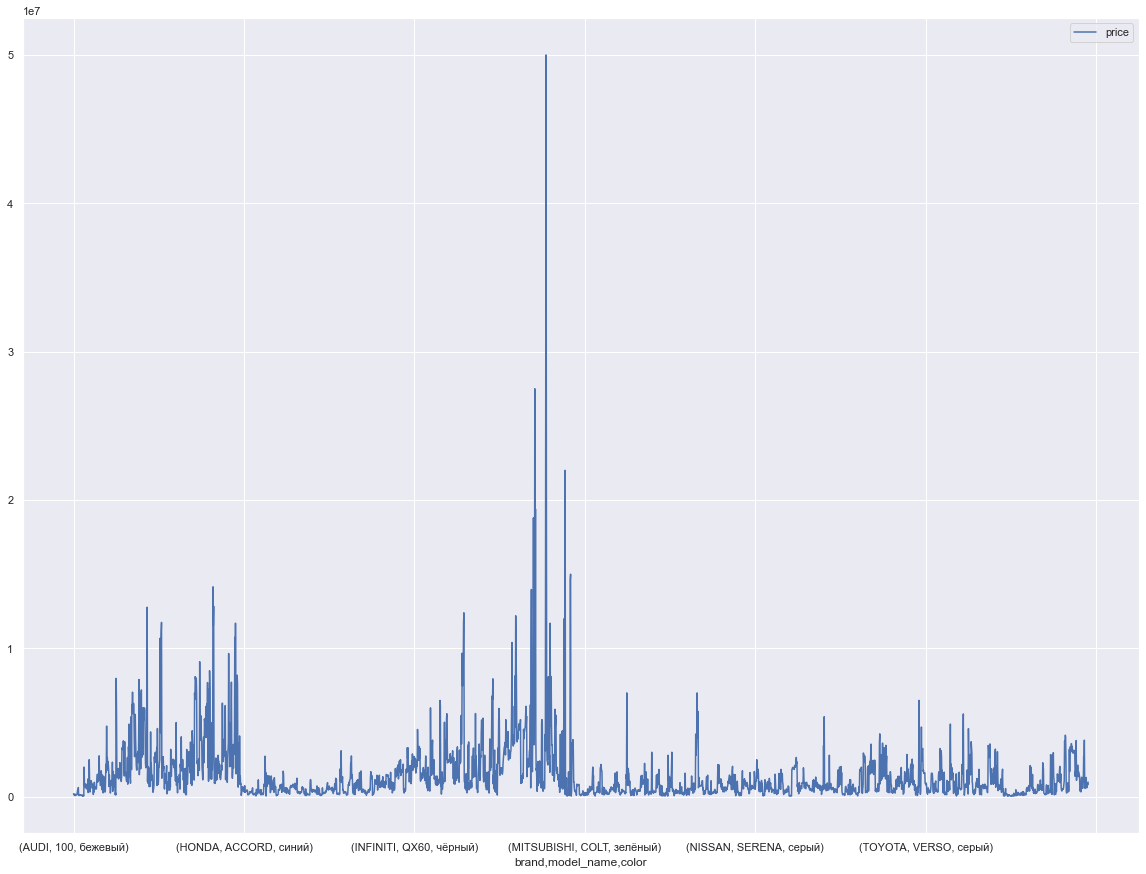

In [73]:
train.groupby(['brand', 'model_name', 'color'])[['price']].median().plot(figsize=(20,15))

Не похоже что есть взаимосвязь

### engineDisplacement - объем двигателя, привёл к числовым значениям

In [74]:
train.engineDisplacement.value_counts()

2.0 LTR    10343
1.6 LTR     5925
3.0 LTR     4757
1.8 LTR     3240
2.5 LTR     3118
3.5 LTR     2800
2.4 LTR     2331
1.4 LTR     2033
1.5 LTR     1160
1.3 LTR      719
1.2 LTR      584
4.5 LTR      567
5.7 LTR      531
4.0 LTR      481
4.7 LTR      426
3.2 LTR      401
2.8 LTR      391
5.6 LTR      390
3.7 LTR      384
2.3 LTR      382
4.4 LTR      371
5.5 LTR      370
2.1 LTR      339
2.7 LTR      321
4.6 LTR      301
2.9 LTR      260
3.6 LTR      244
2.2 LTR      243
5.4 LTR      177
0.7 LTR      174
1.9 LTR      170
4.2 LTR      168
5.0 LTR      143
1.0 LTR      131
3.3 LTR      117
2.6 LTR      115
1.7 LTR      114
 LTR          83
6.2 LTR       68
3.8 LTR       63
3.1 LTR       61
4.3 LTR       42
5.9 LTR       31
6.0 LTR       25
4.1 LTR       24
4.8 LTR       19
5.2 LTR       16
3.4 LTR       15
1.1 LTR        7
6.6 LTR        6
6.3 LTR        5
4.9 LTR        1
5.8 LTR        1
Name: engineDisplacement, dtype: int64

можно преобразовать признак в числовой, для наблюдений без значения объёма занчение укаж 0, т.к. это электродвигатели

In [75]:
pd.reset_option("float_format")

In [77]:
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: float(x[0:3]) if x[0] != ' ' else 0.0)
train['engineDisplacement'] = train['engineDisplacement'].apply(lambda x: float(x[0:3]) if x[0] != ' ' else 0.0)
train.engineDisplacement.value_counts()

2.0    10343
1.6     5925
3.0     4757
1.8     3240
2.5     3118
3.5     2800
2.4     2331
1.4     2033
1.5     1160
1.3      719
1.2      584
4.5      567
5.7      531
4.0      481
4.7      426
3.2      401
2.8      391
5.6      390
3.7      384
2.3      382
4.4      371
5.5      370
2.1      339
2.7      321
4.6      301
2.9      260
3.6      244
2.2      243
5.4      177
0.7      174
1.9      170
4.2      168
5.0      143
1.0      131
3.3      117
2.6      115
1.7      114
0.0       83
6.2       68
3.8       63
3.1       61
4.3       42
5.9       31
6.0       25
4.1       24
4.8       19
5.2       16
3.4       15
1.1        7
6.6        6
6.3        5
4.9        1
5.8        1
Name: engineDisplacement, dtype: int64

In [ ]:
# for i in train[train.engineDisplacement == ' LTR']['car_url']:
#     print(i)

<AxesSubplot:>

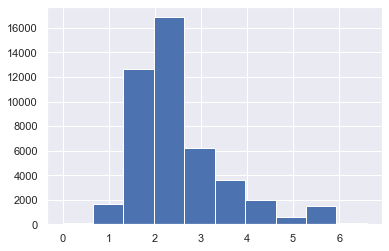

In [78]:
train.engineDisplacement.hist()

<AxesSubplot:>

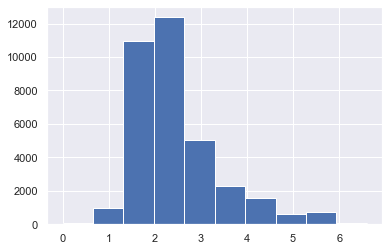

In [79]:
test.engineDisplacement.hist()

Распределение переменной близко к нормальному, а также распределения в тестовой и обуч. выборках схожи

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='engineDisplacement', ylabel='price'>

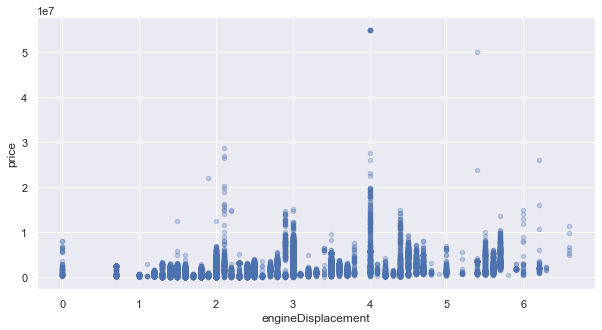

In [80]:
train.plot(x='engineDisplacement', y='price', kind='scatter', figsize=(10,5), alpha=0.3)

<AxesSubplot:xlabel='engineDisplacement'>

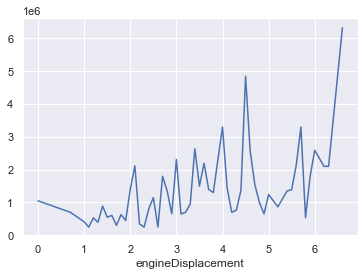

In [81]:
train.groupby('engineDisplacement')['price'].median().plot(ylim=0,grid=True)

In [82]:
train[['engineDisplacement', 'price']].corr()

,engineDisplacement,price
engineDisplacement,1.000000,0.370784
price,0.370784,1.000000


Скорее всего есть зависимость в зависимости от модели

### fuelType - тип топлива, категориальная пер-я

In [83]:
train.fuelType.value_counts(normalize=True)

бензин     0.815084
дизель     0.166991
гибрид     0.016044
электро    0.001837
газ        0.000044
Name: fuelType, dtype: float64

In [84]:
test.fuelType.value_counts(normalize=True)

бензин     0.824569
дизель     0.167214
гибрид     0.006429
электро    0.001586
газ        0.000202
Name: fuelType, dtype: float64

In [85]:
pd.options.display.float_format = '{:,.2f} p'.format

In [86]:
train.groupby('fuelType')['price'].agg(['count', 'mean', 'median'])

,count,mean,median
fuelType,,,
бензин,36832,"1,325,042.72 p","900,000.00 p"
газ,2,"687,500.00 p","687,500.00 p"
гибрид,725,"1,563,931.47 p","1,386,000.00 p"
дизель,7546,"2,677,546.31 p","2,278,500.00 p"
электро,83,"1,786,007.49 p","1,050,000.00 p"


Медианные значения цен отличаются

### mileage - пробег

<AxesSubplot:>

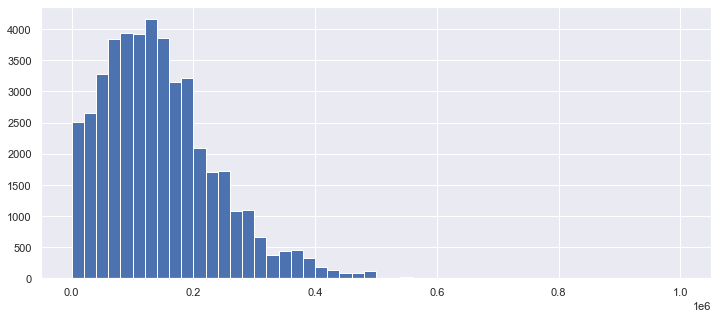

In [87]:
train.mileage.hist(figsize=(12, 5), bins=50)

<AxesSubplot:>

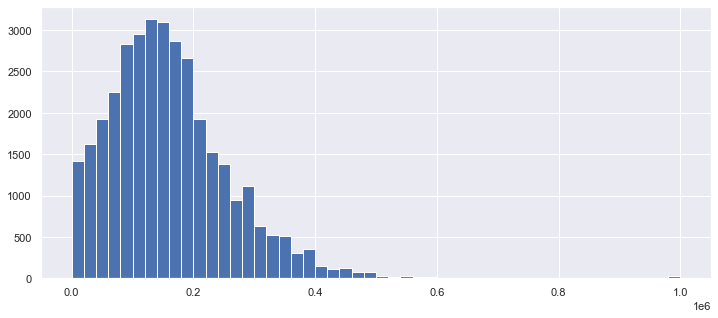

In [88]:
test.mileage.hist(figsize=(12, 5), bins=50)

Распределение ассиметрично, но так как я не планирую строить линейных моделей, это не так существенно

In [89]:
pd.reset_option("float_format")
train[['mileage', 'price']].corr()

,mileage,price
mileage,1.000000,-0.463754
price,-0.463754,1.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='mileage', ylabel='price'>

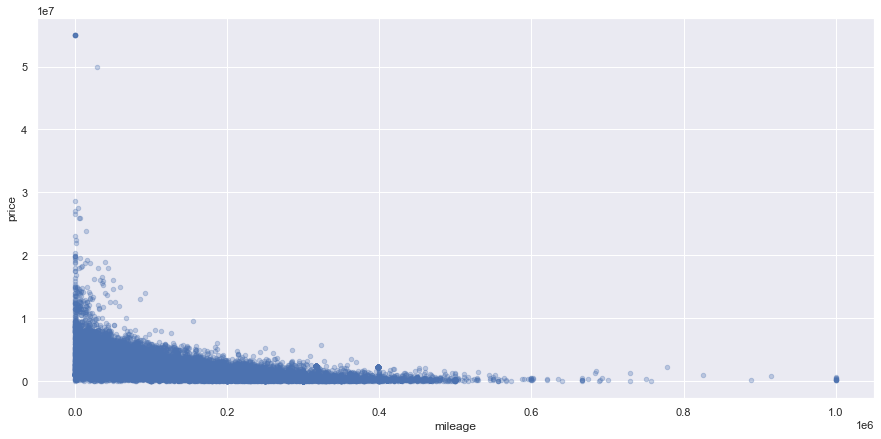

In [90]:
train.plot(x='mileage', y='price', kind='scatter', figsize=(15,7), alpha=0.3)

In [91]:
train['mileage_group'] = pd.qcut(train['mileage'], 10)

In [92]:
test['mileage_group'] = pd.qcut(train['mileage'], 10)

In [93]:
# pd.options.display.float_format = '{:,.2f} p'.format
train.groupby('mileage_group')['price'].agg(['count', 'mean', 'median'])

,count,mean,median
mileage_group,,,
"(0.999, 35470.0]",4519,3.753244e+06,2850000.0
"(35470.0, 63343.2]",4519,2.562881e+06,2100000.0
"(63343.2, 87000.0]",4539,2.040512e+06,1750000.0
"(87000.0, 110974.0]",4498,1.624797e+06,1387500.0
"(110974.0, 133000.0]",4590,1.413832e+06,1199000.0
"(133000.0, 155201.6]",4448,1.187005e+06,1000000.0
"(155201.6, 183000.0]",4614,9.632378e+05,760000.0
"(183000.0, 217000.0]",4437,8.354940e+05,705000.0
"(217000.0, 274860.0]",4505,6.659569e+05,500000.0


<AxesSubplot:xlabel='mileage_group'>

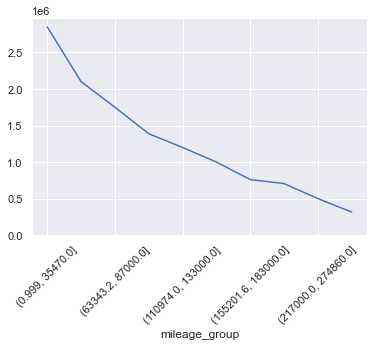

In [94]:
train.groupby('mileage_group')['price'].median().plot(rot=45,ylim=0,grid=True)

In [95]:
outls = outliers(train, 'mileage')
print(f'нижняя граница: {outls[0]}, кол-во выбросов: {outls[1]}, верхняя граница: {outls[2]}, кол-во выбросов: {outls[3]}')

нижняя граница: -107000.0, кол-во выбросов: 0, верхняя граница: 381000.0, кол-во выбросов: 1013


в среднем цена ниже на машины с большим пробегом

### modelDate - год выпуска модели в продажу, числовая пер-я

<AxesSubplot:>

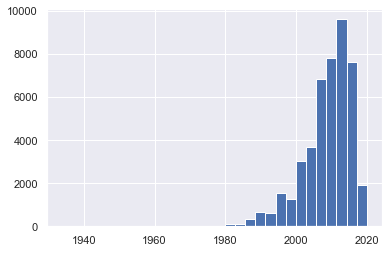

In [96]:
train.modelDate.hist(bins=30)

<AxesSubplot:>

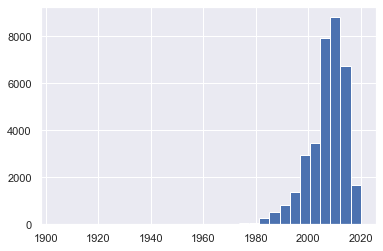

In [97]:
test.modelDate.hist(bins=30)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='modelDate', ylabel='price'>

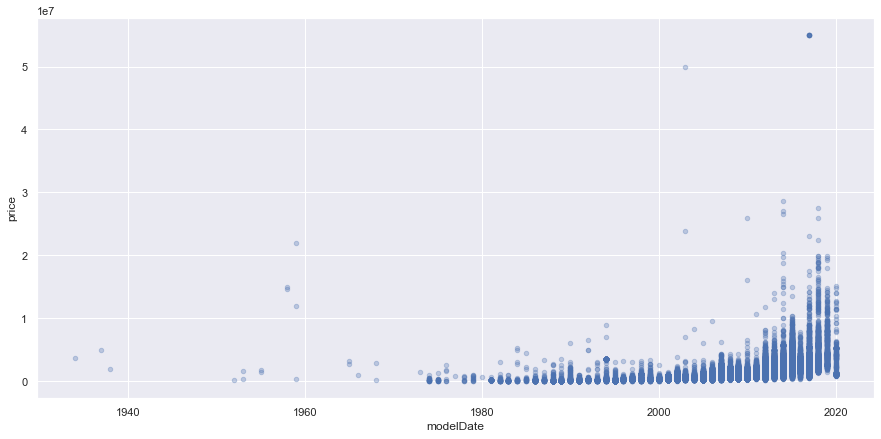

In [98]:
train.plot(x='modelDate', y='price', kind='scatter', figsize=(15,7), alpha=0.3)

In [99]:
pd.options.display.float_format = '{:,.2f} p'.format
train['modelDate_group'] = pd.qcut(train['modelDate'], 8)
train.groupby('modelDate_group')['price'].agg(['count', 'mean', 'median'])

,count,mean,median
modelDate_group,,,
"(1933.999, 2000.0]",5671,"383,247.94 p","250,000.00 p"
"(2000.0, 2005.0]",5728,"587,830.95 p","480,000.00 p"
"(2005.0, 2008.0]",6852,"933,986.89 p","790,000.00 p"
"(2008.0, 2010.0]",4856,"1,083,686.90 p","987,000.00 p"
"(2010.0, 2012.0]",5940,"1,430,247.89 p","1,220,000.00 p"
"(2012.0, 2014.0]",6629,"1,994,075.14 p","1,699,000.00 p"
"(2014.0, 2016.0]",5027,"2,961,013.76 p","2,605,000.00 p"
"(2016.0, 2020.0]",4485,"3,676,751.98 p","2,850,000.00 p"


In [100]:
test['modelDate_group'] = pd.qcut(test['modelDate'], 8)

<AxesSubplot:xlabel='modelDate_group'>

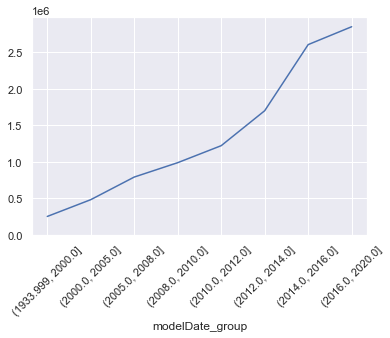

In [101]:
train.groupby('modelDate_group')['price'].median().plot(rot=45,ylim=0,grid=True)

новые модели стоят дороже

###  model_info - не вижу полезной информации

In [102]:
train.model_info[1]

"{'code': 'MULTIVAN', 'name': 'Multivan', 'ru_name': 'Мультивэн', 'morphology': {}, 'nameplate': {'code': '', 'name': '', 'semantic_url': ''}}"

### model_name - категориальные признак, оказывает влияние на цены для каждой модели

In [103]:
train.model_name

0           TIGUAN
1         MULTIVAN
2        PASSAT_CC
3           PASSAT
4             POLO
           ...    
45192           IS
45193           ES
45194           LX
45195           RX
45196           IS
Name: model_name, Length: 45188, dtype: object

### name - дублирует другие признаки, можно удалить

In [104]:
train.name.value_counts()

2.0 AT     5264
3.0 AT     4427
1.6 MT     2968
2.5 AT     2217
3.5 AT     2184
           ... 
1.4 CVT       1
1.1 MT        1
5.0 MT        1
1.0 AMT       1
4.9 AT        1
Name: name, Length: 128, dtype: int64

In [105]:
train[train.engineDisplacement == 2]['name'].value_counts()

2.0 AT     5264
2.0 CVT    2183
2.0 AMT    1808
2.0 MT     1088
Name: name, dtype: int64

### numberOfDoors - кол-во дверей

In [106]:
pd.reset_option("float_format")

In [107]:
train.numberOfDoors.value_counts()

5.0    27730
4.0    15313
2.0     1575
3.0      570
Name: numberOfDoors, dtype: int64

In [108]:
test.numberOfDoors.value_counts()

5    18703
4    14126
2     1206
3      650
0        1
Name: numberOfDoors, dtype: int64

странное значение 0 дверей

In [109]:
print(test[test['numberOfDoors'] == 0]['car_url'].values)

['https://auto.ru/cars/used/sale/mercedes/simplex/1093802104-d76601f9/']


In [110]:
print(test[test['numberOfDoors'] == 0])

        bodyType     brand                                            car_url  \
16944  кабриолет  MERCEDES  https://auto.ru/cars/used/sale/mercedes/simple...   

       color complectation_dict  \
16944  белый            no_info   

                                             description  engineDisplacement  \
16944  на ходу. 1904 год. стоит в гараже, пылится.Кат...                 5.3   

      enginePower equipment_dict fuelType  ...   vehicleConfiguration  \
16944      32 N12        no_info   бензин  ...  CABRIO MECHANICAL 5.3   

       vehicleTransmission    vendor   Владельцы           Владение       ПТС  \
16944         механическая  EUROPEAN  1 владелец  6 лет и 8 месяцев  Оригинал   

       Привод    Руль         mileage_group     modelDate_group  
16944  задний  Правый  (155201.6, 183000.0]  (1903.999, 1999.0]  

[1 rows x 32 columns]


### parsing_unixtime - буду использовать только 2 даты для вычисления цен

## productionDate - год выпуска автомобиля

<AxesSubplot:>

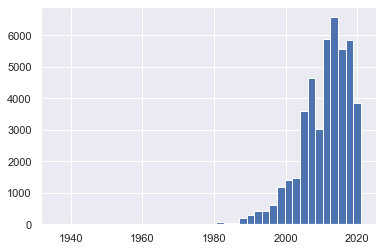

In [111]:
train.productionDate.hist(bins=40)

<AxesSubplot:>

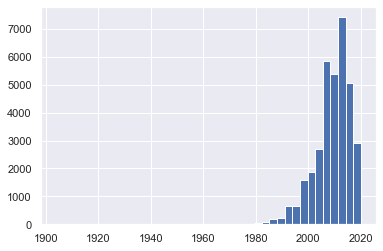

In [112]:
test.productionDate.hist(bins=40)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='productionDate', ylabel='price'>

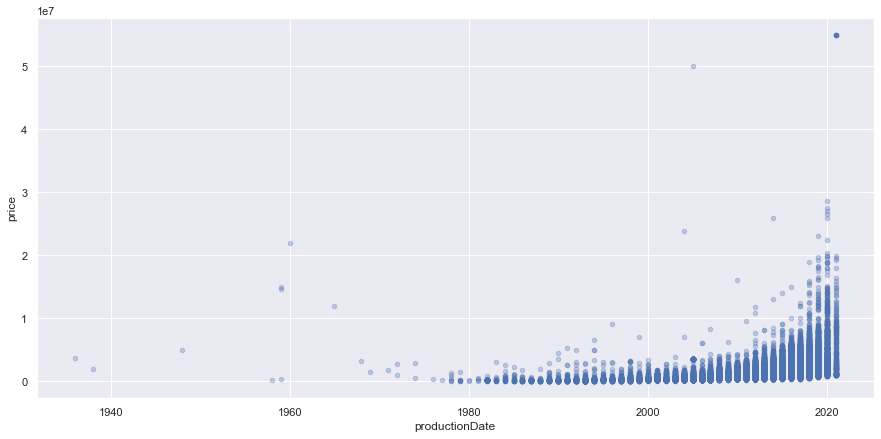

In [113]:
train.plot(x='productionDate', y='price', kind='scatter', figsize=(15,7), alpha=0.3)

In [114]:
pd.options.display.float_format = '{:,.2f} p'.format
train['productionDate_group'] = pd.qcut(train['productionDate'], 8)
train.groupby('productionDate_group')['price'].agg(['count', 'mean', 'median'])

,count,mean,median
productionDate_group,,,
"(1935.999, 2003.0]",6176,"363,148.05 p","255,000.00 p"
"(2003.0, 2007.0]",5486,"646,778.25 p","525,000.00 p"
"(2007.0, 2010.0]",5787,"880,020.25 p","760,000.00 p"
"(2010.0, 2012.0]",5888,"1,150,918.52 p","1,000,000.00 p"
"(2012.0, 2014.0]",6578,"1,466,314.92 p","1,300,000.00 p"
"(2014.0, 2016.0]",5559,"2,184,421.98 p","1,895,000.00 p"
"(2016.0, 2018.0]",5847,"2,641,794.11 p","2,299,000.00 p"
"(2018.0, 2021.0]",3867,"3,981,561.21 p","2,970,000.00 p"


In [115]:
test['productionDate_group'] = pd.qcut(train['productionDate'], 8)

In [117]:
pd.reset_option("float_format")

In [118]:
train[['productionDate', 'price']].corr()

,productionDate,price
productionDate,1.000000,0.497197
price,0.497197,1.000000


Новые автомобили дороже

### sell_id - пока не знаю что с ним делать

<AxesSubplot:>

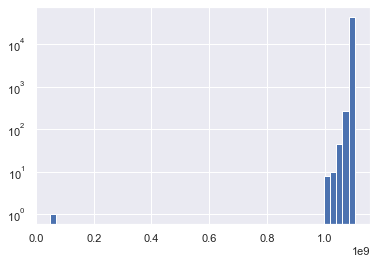

In [119]:
train.sell_id.hist(bins=50, log=True)

<AxesSubplot:>

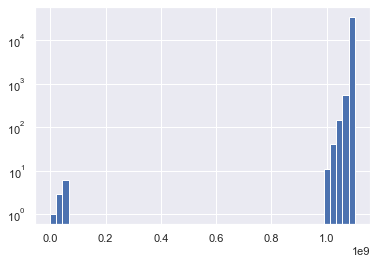

In [120]:
test.sell_id.hist(bins=50, log=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='sell_id', ylabel='price'>

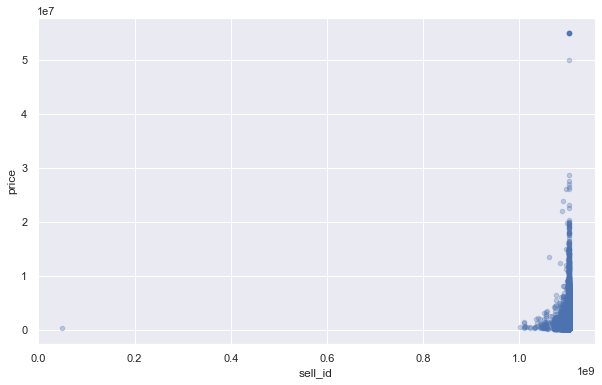

In [121]:
train.plot(x='sell_id', y='price', kind='scatter', figsize=(10,6), alpha=0.3)

### super_gen - можно собрать дополнитнльные данные по автомобилям
displacement  
gear_type  
power_kvt  
acceleration  
clearance_min  
fuel_rate
## В тестовом датасете совсем другие значения - признак использовать не получится

In [122]:
test.super_gen[100]

'{"id":"6038950","displacement":1197,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":105,"power_kvt":77,"human_name":"1.2 AMT (105 л.с.)","acceleration":12,"clearance_min":180,"fuel_rate":6.4}'

In [123]:
train.super_gen[200]

"{'id': '3749621', 'name': 'I', 'ru_name': '1', 'year_from': 2007, 'year_to': 2011, 'price_segment': 'MEDIUM'}"

### vehicleConfiguration - дублирует другие признаки которые я использую в моделировании
значения заполнены не все, использовать для предсказания этот признак не буду

In [124]:
for i in train.vehicleConfiguration.values:
    if len(i.split(' ')) < 3:
        print (i)

HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
VAN AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
ALLROAD_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBACK_5_DOORS AUTOMATIC
HATCHBAC

In [125]:
train.engineDisplacement.values

array([2. , 2. , 1.8, ..., 5.7, 3.5, 2.5])

### vehicleTransmission - тип коробки передач

In [128]:
train.vehicleTransmission.value_counts(normalize=True)

автоматическая      0.587767
механическая        0.175644
вариатор            0.122754
роботизированная    0.113836
Name: vehicleTransmission, dtype: float64

In [129]:
test.vehicleTransmission.value_counts(normalize=True)

автоматическая      0.564954
механическая        0.207836
вариатор            0.115291
роботизированная    0.111918
Name: vehicleTransmission, dtype: float64

In [131]:
pd.options.display.float_format = '{:,.2f}'.format

In [132]:
train.groupby('vehicleTransmission')['price'].agg(['count', 'mean', 'median'])

,count,mean,median
vehicleTransmission,,,
автоматическая,26560,"1,917,655.18","1,378,000.00"
вариатор,5547,"1,186,440.94","1,100,000.00"
механическая,7937,"553,485.45","450,000.00"
роботизированная,5144,"1,630,069.68","1,290,000.00"


Выделяется категория механических коробок передач - они дешевле

### vendor

In [133]:
test.vendor.value_counts()

EUROPEAN    20682
JAPANESE    14004
Name: vendor, dtype: int64

In [134]:
train.vendor.value_counts()

EUROPEAN    24140
JAPANESE    21048
Name: vendor, dtype: int64

### Владельцы 

In [135]:
pd.reset_option("float_format")

In [136]:
train['Владельцы'].value_counts(normalize=True)

3 или более    0.444499
1 владелец     0.305103
2 владельца    0.250398
Name: Владельцы, dtype: float64

In [137]:
test['Владельцы'].value_counts(normalize=True)

3 или более    0.460042
1 владелец     0.272704
2 владельца    0.267255
Name: Владельцы, dtype: float64

In [138]:
pd.options.display.float_format = '{:,.2f}'.format
train.groupby('Владельцы')['price'].agg(['count', 'mean', 'median'])

,count,mean,median
Владельцы,,,
1 владелец,13787,"2,330,554.51","1,760,000.00"
2 владельца,11315,"1,675,511.84","1,297,000.00"
3 или более,20086,"956,010.68","677,000.00"


чемь меньше было владельцев тем выше цена

### Владение 

In [141]:
test['Владение'].value_counts(normalize=True)

no_info                0.65
1 год и 10 месяцев     0.01
2 года                 0.01
1 год                  0.01
1 год и 1 месяц        0.01
                       ... 
31 год и 5 месяцев     0.00
19 лет и 5 месяцев     0.00
42 года и 10 месяцев   0.00
19 лет                 0.00
20 лет и 5 месяцев     0.00
Name: Владение, Length: 276, dtype: float64

In [142]:
train['Владение'].value_counts(normalize=True)

no_info               0.77
5 месяцев             0.01
10 месяцев            0.01
1 год и 7 месяцев     0.01
7 месяцев             0.01
                      ... 
20 лет                0.00
23 года и 5 месяцев   0.00
21 год и 5 месяцев    0.00
17 лет и 5 месяцев    0.00
16 лет и 8 месяцев    0.00
Name: Владение, Length: 254, dtype: float64

Признак возможно хорошо подходит для предсказания цены, но очень много пропущенных значений

In [143]:
test['Владение'].nunique(), train['Владение'].nunique()

(276, 254)

количество уникальных значений не совпадает, это может быть проблемой при построении модели, заменю категориальный признак на количество месяцев, no_info - заменю на макимальное значение + 1, хотя из-за большого кол-ва пропусков врядли признак будет полезен

In [144]:
import re

def to_month_count(row):
    month_pat = r'.*?((\d*) м)'
    year_pat = r'(\d*) (год|лет)'
    
    if row == 'no_info':
        return 330
    
    match_month = re.findall(month_pat, row, re.IGNORECASE)
    if match_month:
        monthes = int(match_month[0][1])
    else:
        monthes = 0
    
    match_yearh = re.findall(year_pat, row, re.IGNORECASE)
    if match_yearh:
        years = int(match_yearh[0][0])
    else:
        years = 0
        
    return 12*years + monthes


In [145]:
train['Владение'] = train['Владение'].apply(to_month_count)
test['Владение'] = test['Владение'].apply(to_month_count)

<AxesSubplot:>

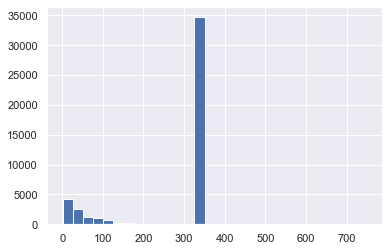

In [146]:
train['Владение'].hist(bins=30)

In [147]:
outls = outliers(train, 'Владение')
print(f'нижняя граница: {outls[0]}, кол-во выбросов: {outls[1]}, верхняя граница: {outls[2]}, кол-во выбросов: {outls[3]}')

нижняя граница: 330.0, кол-во выбросов: 10471, верхняя граница: 330.0, кол-во выбросов: 11


### ПТС 

In [148]:
pd.reset_option("float_format")

In [149]:
train['ПТС'].value_counts(normalize=True)

Оригинал    0.847482
Дубликат    0.152518
Name: ПТС, dtype: float64

In [150]:
test['ПТС'].value_counts(normalize=True)

Оригинал    0.867756
Дубликат    0.132244
Name: ПТС, dtype: float64

In [152]:
pd.options.display.float_format = '{:,.2f} р'.format

In [153]:
train.groupby('ПТС')['price'].agg(['count', 'mean', 'median', 'std'])

,count,mean,median,std
ПТС,,,,
Дубликат,6892,"870,864.23 р","570,000.00 р","950,636.17 р"
Оригинал,38296,"1,678,770.78 р","1,199,000.00 р","1,826,195.90 р"


Похоже с дубликатом продают в основном дешовые автомобили

### Привод

In [156]:
pd.reset_option("float_format")

In [157]:
train['Привод'].value_counts(normalize=True)

полный      0.497145
передний    0.410264
задний      0.092591
Name: Привод, dtype: float64

In [158]:
test['Привод'].value_counts(normalize=True)

передний    0.448740
полный      0.433028
задний      0.118232
Name: Привод, dtype: float64

In [159]:
pd.options.display.float_format = '{:,.2f} р'.format

In [160]:
train.groupby('Привод')['price'].agg(['count', 'mean', 'median', 'std'])

,count,mean,median,std
Привод,,,,
задний,4184,"1,331,148.37 р","989,500.00 р","2,696,116.89 р"
передний,18539,"806,817.98 р","639,000.00 р","674,944.33 р"
полный,22465,"2,215,227.18 р","1,729,000.00 р","1,869,616.17 р"


полный привод в среднем дороже заднего и переднего

### Руль

In [161]:
pd.reset_option("float_format")

In [162]:
train['Руль'].value_counts(normalize=True)

Левый     0.937638
Правый    0.062362
Name: Руль, dtype: float64

In [163]:
test['Руль'].value_counts(normalize=True)

Левый     0.959667
Правый    0.040333
Name: Руль, dtype: float64

In [164]:
pd.options.display.float_format = '{:,.2f} р'.format

In [165]:
train.groupby('Руль')['price'].agg(['count', 'mean', 'median', 'std'])

,count,mean,median,std
Руль,,,,
Левый,42370,"1,622,958.37 р","1,150,000.00 р","1,778,083.99 р"
Правый,2818,"542,035.43 р","380,000.00 р","503,113.15 р"


так как автомобили продаются  в РФ вполне закономерно что с правым рулём дешевле

## enginePower

In [ ]:
# for i in train['enginePower'].value_counts().index:
#     print(i)

создам числовой признак

In [166]:
train['enginePower'] = train['enginePower'].apply(lambda x: int(x[:3]) if x[3] == ' ' else int(x[:2]))
test['enginePower'] = test['enginePower'].apply(lambda x: int(x[:3]) if x[3] == ' ' else int(x[:2]))

<AxesSubplot:>

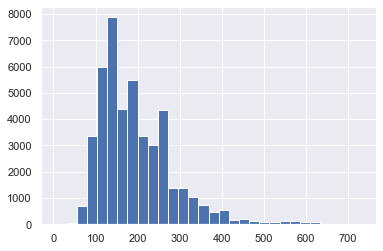

In [167]:
train['enginePower'].hist(bins=30)

<AxesSubplot:>

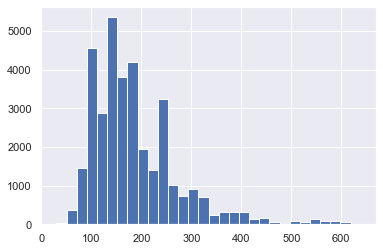

In [168]:
test['enginePower'].hist(bins=30)

In [169]:
outls = outliers(train, 'enginePower')
print(f'нижняя граница: {outls[0]}, кол-во выбросов: {outls[1]}, верхняя граница: {outls[2]}, кол-во выбросов: {outls[3]}')

нижняя граница: -27.5, кол-во выбросов: 0, верхняя граница: 408.5, кол-во выбросов: 1063


In [170]:
pd.reset_option("float_format")

In [171]:
train[['enginePower', 'price']].corr()

,enginePower,price
enginePower,1.000000,0.547119
price,0.547119,1.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='enginePower', ylabel='price'>

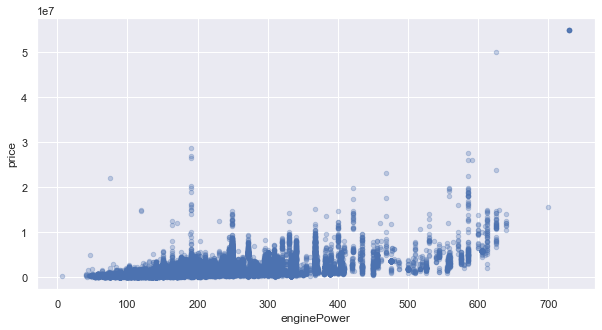

In [172]:
train.plot(x='enginePower', y='price', kind='scatter', figsize=(10,5), alpha=0.3)

Мощность двигателя и цена автомобиля имеют зависимость

## description - не успеваю

In [173]:
test.description[0]

'Все автомобили, представленные в продаже, проходят тщательную проверку по более 40 параметрам. Предоставляем гарантию юридической чистоты, а так же год технической гарантии на двигатель и КПП. Бесплатный тест-драйв. Возможно оформление автомобиля в кредит!\n\nПреимущества автокредитования:\n— Первоначальный взнос от 0%;\n— Более 30 кредитных программ;\n— Процентная ставка от 6% годовых;\n— Срок кредита от 6 месяцев до 7 лет;\n— Оформление кредита по двум документам;\n— Досрочное погашение без штрафов и комиссий;\n— Сумма кредита до 2 млн рублей;\n— Оформление КАСКО – по желанию;\n— Без справок и поручителей.\n\nСотрудничаем с 12 аккредитованными и сертифицированными банками РФ, среднее время ожидания решения банка 20–30 минут.\n\nПри покупке автомобиля по программе «Trade-in – выгодный обмен» или в кредит, получите дополнительную скидку до 80 000 рублей на данный автомобиль!\n\nЗаписаться на тест-драйв, а так же получить подробную информацию можно у специалистов автоцентра по указанно

## image - есть не уникальные занчения, но 

In [174]:
train.image.count(), train.image.nunique()

(45188, 36463)

In [175]:
train.image.count(), test.image.nunique()

(45188, 34557)

In [176]:
# images = train.image.value_counts()
# images[images > 1]

imgs = pd.DataFrame({'img' :train.image.value_counts().index, 'num' : train.image.value_counts().values})
imgs_list = list(imgs[imgs.num > 1].img)

In [177]:
train['unique_img'] = train['image'].apply(lambda x: 0 if x in imgs_list else 1)

In [178]:
train['unique_img'].value_counts()

1    35603
0     9585
Name: unique_img, dtype: int64

In [179]:
train.brand.value_counts()

TOYOTA        4772
MERCEDES      4661
VOLKSWAGEN    4475
BMW           4358
AUDI          4191
NISSAN        3828
SKODA         3590
MITSUBISHI    3586
HONDA         3562
LEXUS         3507
VOLVO         2865
INFINITI      1793
Name: brand, dtype: int64

In [180]:
train.groupby(['brand', 'unique_img'])['price'].agg(['count', 'median'])

count     median
brand      unique_img                  
AUDI       0             980   839000.0
           1            3211  1225000.0
BMW        0            1103  1100000.0
           1            3255  2150000.0
HONDA      0             448   560000.0
           1            3114   530000.0
INFINITI   0             310  1500000.0
           1            1483  1430000.0
LEXUS      0             399  1550000.0
           1            3108  2157500.0
MERCEDES   0            1412  1549000.0
           1            3249  2530000.0
MITSUBISHI 0             549   400000.0
           1            3037   699000.0
NISSAN     0             657   687000.0
           1            3171   799999.0
SKODA      0             490   775000.0
           1            3100   725000.0
TOYOTA     0            1583   897000.0
           1            3189  1557000.0
VOLKSWAGEN 0            1327   700000.0
           1            3148   885000.0
VOLVO      0             327   460000.0
           1            2538   850000.0

По большинству моделей в среднем цены в объявлениях с уникальными картинками выше

In [181]:
test['unique_img'] = test['image'].apply(lambda x: 0 if x in imgs_list else 1)

In [182]:
train.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,Владельцы,Владение,ПТС,Привод,Руль,price,mileage_group,modelDate_group,productionDate_group,unique_img
0,внедорожник 5 дв.,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/tigu...,белый,no_info,КЛЮЧАВТО | автомобили с пробегом — направление...,2.0,170,"{'cruise-control': True, 'airbag-driver': True...",бензин,...,2 владельца,330,Оригинал,полный,Левый,1099000.0,"(87000.0, 110974.0]","(2010.0, 2012.0]","(2014.0, 2016.0]",1
1,минивэн,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/mult...,коричневый,no_info,Авто в идеальном состоянии. Немецкая сборка. М...,2.0,180,"{'cruise-control': True, 'esp': True, 'airbag-...",дизель,...,3 или более,330,Оригинал,полный,Левый,1895000.0,"(155201.6, 183000.0]","(2008.0, 2010.0]","(2010.0, 2012.0]",1
2,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/pass...,чёрный,no_info,Артикул: 26853\n\nПРИ ПОКУПКЕ АВТОМОБИЛЯ В КРЕ...,1.8,152,"{'asr': True, 'tinted-glass': True, 'esp': Tru...",бензин,...,2 владельца,330,Оригинал,передний,Левый,885000.0,"(63343.2, 87000.0]","(2010.0, 2012.0]","(2010.0, 2012.0]",1
3,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/pass...,серый,no_info,КЛЮЧАВТО | автомобили с пробегом — направление...,1.4,150,"{'cruise-control': True, 'engine-proof': True,...",бензин,...,1 владелец,330,Оригинал,передний,Левый,2099000.0,"(0.999, 35470.0]","(2012.0, 2014.0]","(2018.0, 2021.0]",1
4,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/polo...,белый,no_info,СКИДКА НА АВТОМОБИЛЬ СЕГОДНЯ ДО 21:00 !!!\nАвт...,1.6,90,no_info,бензин,...,3 или более,330,Оригинал,передний,Левый,649990.0,"(35470.0, 63343.2]","(2012.0, 2014.0]","(2014.0, 2016.0]",1


## Baseline

Так как данных в обучающей выборки мало, а submition на Kaggle для этого соревнования происходит практиченски мгновенно, я не разделял выборку на train и test. Я обучал модель на всём трейне и проверял на тесте на kagle

## данные для модели

In [183]:
train_naiv = train[['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType','mileage', 'model_name', 'numberOfDoors', 'productionDate', 'sell_id',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'price']].copy()

test_naiv = test[['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType','mileage', 'model_name', 'numberOfDoors', 'productionDate', 'sell_id',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль']].copy()

In [184]:
cat_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_name',
       'vehicleTransmission', 'vendor', 'Владельцы', 'ПТС', 'Привод', 'Руль']
num_features = ['enginePower', 'engineDisplacement','mileage', 'numberOfDoors', 
                'productionDate', 'sell_id', 'Владение', 'unique_img']

Цену переведу в доллары по курсу на день парсинга

In [185]:
train_naiv['price'] = train_naiv['price'].apply(lambda x: x*0.013)

In [ ]:
#77.03

## Случайный лес

In [186]:
from feature_engine.encoding import OneHotEncoder as fe_OneHotEncoder
from feature_engine.encoding import OrdinalEncoder
from feature_engine.encoding import RareLabelEncoder

In [187]:
from sklearn.ensemble import RandomForestRegressor

In [188]:
X = train_naiv.drop('price', axis=1)
y = train_naiv['price']

In [189]:
X.shape, test_naiv.shape

((45188, 18), (34686, 18))

Преобразую категориальные переменные:  
так как названий моделей много и есть несовпадения в трейне и тесет, закодирую все малочисленные категории в отдельную  
остальные признаки закодирую с помомщью Ordered Integer Encoding

In [ ]:
# def encode_cat(X, y, test_df, variables_rare, cat_features):

#     rare_encoder = RareLabelEncoder(
#         tol=0.01,  # minimal percentage to be considered non-rare

#         variables=variables_rare # variables to re-group
#     )

#     rare_encoder.fit(X)
#     X = rare_encoder.transform(X)
#     test_df = rare_encoder.transform(test_df)

#     ordinal_enc = OrdinalEncoder(
#         encoding_method='ordered',
#         variables=cat_features)

#     ordinal_enc.fit(X, y)
#     X = ordinal_enc.transform(X)
#     test_df = ordinal_enc.transform(test_df)
    
#     return X, test_df

In [190]:
# X, test_naiv = encode_cat(X, y, test_naiv, ['model_name'], cat_features)
var_rare = ['model_name']
X, test_naiv = encode_cat(X, y, test_naiv, var_rare, cat_features)

In [191]:
X.head()

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,model_name,numberOfDoors,productionDate,sell_id,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль
0,19,5,14,2.0,170,1,92872.0,17,5.0,2015.0,1.101165e+09,3,1,1,330,1,2,1
1,18,5,13,2.0,180,4,177317.0,21,4.0,2011.0,1.102047e+09,2,1,0,330,1,2,1
2,12,5,15,1.8,152,1,84000.0,21,4.0,2012.0,1.103781e+09,2,1,1,330,1,0,1
3,12,5,12,1.4,150,1,17664.0,3,4.0,2019.0,1.103831e+09,2,1,2,330,1,0,1
4,12,5,14,1.6,90,1,62807.0,4,4.0,2016.0,1.103808e+09,0,1,0,330,1,0,1


In [193]:
test_naiv.head()

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,model_name,numberOfDoors,productionDate,sell_id,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль
0,13,3,11,1.2,105,1,74000,7,5,2014,1100575026,2,1,0,330,1,0,1
1,13,3,15,1.6,110,1,60563,7,5,2017,1100549428,0,1,2,330,1,0,1
2,13,3,12,1.8,152,1,88000,21,5,2014,1100658222,2,1,2,330,1,0,1
3,13,3,13,1.6,110,1,95000,7,5,2014,1100937408,3,1,2,330,1,0,1
4,13,3,14,1.8,152,1,58536,7,5,2012,1101037972,3,1,2,330,1,0,1


In [ ]:
# normalize_feature(X, num_features)
# normalize_feature(test_naiv, num_features)

In [195]:
clf = RandomForestRegressor(n_estimators=1000, max_features=6) #211

In [196]:
clf.fit(X, y)

RandomForestRegressor(max_features=6, n_estimators=1000)

In [197]:
pred = np.round((clf.predict(test_naiv) * 77.03))
pred

array([ 665514., 1007981.,  911022., ...,  252026., 1308087., 1110140.])

In [198]:
sample_submission['price'] = pred
sample_submission.to_csv('submissions/submission_b_1.csv', index=False)
sample_submission.head(10)
#47.12527
# 100+
# 50
# 45.02177 !!
# 43.11838 вонхот по всем значениям
# 45.53169
# 41.46748
# 22.86344 двойной энкод и без нормализации

,sell_id,price
0,1100575026,665514.0
1,1100549428,1007981.0
2,1100658222,911022.0
3,1100937408,730287.0
4,1101037972,799200.0
5,1100912634,916656.0
6,1101228730,722796.0
7,1100165896,418535.0
8,1100768262,2140841.0
9,1101218501,901728.0


Первый результат был MAPE = <b>47.12527</b>  
Потом я подобрал метод обработки категориальных переменных и получил MAPE = <b>22.86344</b>

Посмотрим значимость признаков для модели:

In [199]:
pd.DataFrame({
    'feature': X.columns,
    'importance': clf.feature_importances_
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

,feature,importance
0,enginePower,0.253348
1,productionDate,0.247174
2,mileage,0.166967
3,engineDisplacement,0.109388
4,brand,0.052129
5,Привод,0.038774
6,sell_id,0.027584
7,model_name,0.022682
8,bodyType,0.019383
9,Владельцы,0.012558


## Catboost BS

In [200]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X, y,
         #cat_features=cat_features,
         eval_set=(X, y),
         verbose_eval=0,
         use_best_model=True,
         plot=True
         )

# # model.save_model('catboost_single_model_2_baseline.model')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [201]:
pred = np.round((model.predict(test_naiv) * 77.03))
pred

array([ 664702.,  982957.,  909021., ...,  331905., 1511014., 1232074.])

In [202]:
sample_submission['price'] = pred
sample_submission.to_csv('submissions/submission_b.csv', index=False)
sample_submission.head(10)
# 27.71388
# 23.63111 без моделей
# 22.86344 своя кодировка


,sell_id,price
0,1100575026,664702.0
1,1100549428,982957.0
2,1100658222,909021.0
3,1100937408,712858.0
4,1101037972,769533.0
5,1100912634,921533.0
6,1101228730,804194.0
7,1100165896,459820.0
8,1100768262,2168870.0
9,1101218501,970609.0


Выводы: при создании baseline я использовал 2 аллгоритма  
Random Forest: MAPE = 22.86344  
Catboost: MAPE = 22.86344  
Для модели использовал не все признаки и не подбирал парметры, единственное подобрал метод кодирования категориальных переменных.  
Для улучшения предсказательной способности момента, можно попробовать  
+ собрать побольше информации из имеющихся признаков, например  image, enginePower, sell_id, год авто, super_gen, description, model_info
+ создать новые признаки
+ проверить выбросы
+ оптимизировать параметры алгоритмов 

*Признаки которые не вошли в наивную модель я рассмотрел выше, в итог добавил признак unique_img, изменил тип enginePower

## Новые признаки

Создам переменную возраст автомобиля

In [203]:
train['age'] = 2021 - train['productionDate']
test['age'] = 2020 - test['productionDate']
train[['age', 'price']].corr()

,age,price
age,1.000000,-0.497197
price,-0.497197,1.000000


In [204]:
train[['age', 'modelDate', 'productionDate', 'price']].corr()

,age,modelDate,productionDate,price
age,1.000000,-0.974813,-1.000000,-0.497197
modelDate,-0.974813,1.000000,0.974813,0.488829
productionDate,-1.000000,0.974813,1.000000,0.497197
price,-0.497197,0.488829,0.497197,1.000000


Признак сильно коррелирует с другими, так что для модели его использовать не буду

Попробую различные групировки данных, возможно найдутся кластеры, которые можно выделить и использовать для предсказания. Буду использовать алг K-Means для этого придётся объединить датафреймы

In [205]:
test['sample'] = 0
train['sample'] = 1

df = test.append(train, sort=False).reset_index(drop=True)

In [206]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   bodyType              34686 non-null  object  
 1   brand                 34686 non-null  object  
 2   car_url               34686 non-null  object  
 3   color                 34686 non-null  object  
 4   complectation_dict    34686 non-null  object  
 5   description           34686 non-null  object  
 6   engineDisplacement    34686 non-null  float64 
 7   enginePower           34686 non-null  int64   
 8   equipment_dict        34686 non-null  object  
 9   fuelType              34686 non-null  object  
 10  image                 34686 non-null  object  
 11  mileage               34686 non-null  int64   
 12  modelDate             34686 non-null  int64   
 13  model_info            34686 non-null  object  
 14  model_name            34686 non-null  object  
 15  na

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79874 entries, 0 to 79873
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype            
---  ------                --------------  -----            
 0   bodyType              79874 non-null  object           
 1   brand                 79874 non-null  object           
 2   car_url               79874 non-null  object           
 3   color                 79874 non-null  object           
 4   complectation_dict    79874 non-null  object           
 5   description           79874 non-null  object           
 6   engineDisplacement    79874 non-null  float64          
 7   enginePower           79874 non-null  int64            
 8   equipment_dict        79874 non-null  object           
 9   fuelType              79874 non-null  object           
 10  image                 79874 non-null  object           
 11  mileage               79874 non-null  float64          
 12  modelDate             79874 non-

In [208]:
from sklearn.cluster import KMeans

In [209]:
temp = df[["brand", "mileage", "age"]]
temp = pd.get_dummies(temp, columns=["brand"])


temp_scaled = (temp - temp.mean(axis=0)) / temp.std(axis=0)
temp_scaled.head()

,mileage,age,brand_AUDI,brand_BMW,brand_HONDA,brand_INFINITI,brand_LEXUS,brand_MERCEDES,brand_MITSUBISHI,brand_NISSAN,brand_SKODA,brand_TOYOTA,brand_VOLKSWAGEN,brand_VOLVO
0,-0.805857,-0.635157,-0.324558,-0.352567,-0.250381,-0.185749,-0.239731,-0.352791,-0.295861,-0.338721,3.408253,-0.349282,-0.353643,-0.239351
1,-0.942657,-1.067711,-0.324558,-0.352567,-0.250381,-0.185749,-0.239731,-0.352791,-0.295861,-0.338721,3.408253,-0.349282,-0.353643,-0.239351
2,-0.663325,-0.635157,-0.324558,-0.352567,-0.250381,-0.185749,-0.239731,-0.352791,-0.295861,-0.338721,3.408253,-0.349282,-0.353643,-0.239351
3,-0.592060,-0.635157,-0.324558,-0.352567,-0.250381,-0.185749,-0.239731,-0.352791,-0.295861,-0.338721,3.408253,-0.349282,-0.353643,-0.239351
4,-0.963293,-0.346788,-0.324558,-0.352567,-0.250381,-0.185749,-0.239731,-0.352791,-0.295861,-0.338721,3.408253,-0.349282,-0.353643,-0.239351


In [210]:
kmeans = KMeans(n_clusters=2, n_init=20, random_state=RANDOM_SEED)
kmeans.fit_predict(temp_scaled)
df["kl_brand_mil_age"] = kmeans.fit_predict(temp_scaled)
df["kl_brand_mil_age"] = df["kl_brand_mil_age"].astype("category")

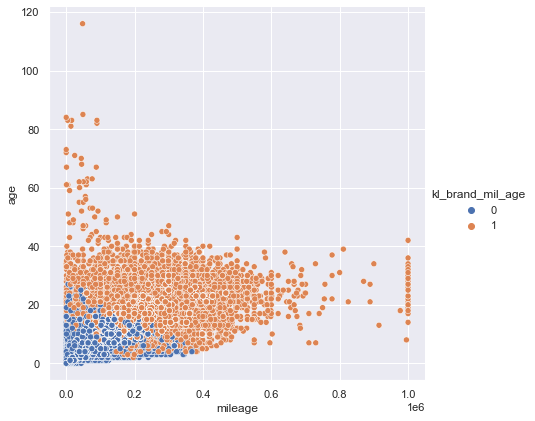

In [211]:
sns.relplot(
    x="mileage", y="age", hue="kl_brand_mil_age", data=df, height=6,
);

In [212]:
df.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'mileage_group', 'modelDate_group',
       'productionDate_group', 'unique_img', 'age', 'sample', 'price',
       'kl_brand_mil_age'],
      dtype='object')

In [213]:
df[df['sample'] == 1].groupby('kl_brand_mil_age')['price'].agg(['count', 'median'])

,count,median
kl_brand_mil_age,,
0,29911,1547000.0
1,15277,490000.0


Оставлю этот кластер для модели

In [214]:
temp2 = df[["brand", "numberOfDoors", "engineDisplacement", "mileage", "age"]] # "mileage", 
temp2 = pd.get_dummies(temp2, columns=["brand"])

temp_scaled2 = (temp2 - temp2.mean(axis=0)) / temp2.std(axis=0)
temp_scaled2.head()

,numberOfDoors,engineDisplacement,mileage,age,brand_AUDI,brand_BMW,brand_HONDA,brand_INFINITI,brand_LEXUS,brand_MERCEDES,brand_MITSUBISHI,brand_NISSAN,brand_SKODA,brand_TOYOTA,brand_VOLKSWAGEN,brand_VOLVO
0,0.719696,-1.229544,-0.805857,-0.635157,-0.324558,-0.352567,-0.250381,-0.185749,-0.239731,-0.352791,-0.295861,-0.338721,3.408253,-0.349282,-0.353643,-0.239351
1,0.719696,-0.828395,-0.942657,-1.067711,-0.324558,-0.352567,-0.250381,-0.185749,-0.239731,-0.352791,-0.295861,-0.338721,3.408253,-0.349282,-0.353643,-0.239351
2,0.719696,-0.627821,-0.663325,-0.635157,-0.324558,-0.352567,-0.250381,-0.185749,-0.239731,-0.352791,-0.295861,-0.338721,3.408253,-0.349282,-0.353643,-0.239351
3,0.719696,-0.828395,-0.592060,-0.635157,-0.324558,-0.352567,-0.250381,-0.185749,-0.239731,-0.352791,-0.295861,-0.338721,3.408253,-0.349282,-0.353643,-0.239351
4,0.719696,-0.627821,-0.963293,-0.346788,-0.324558,-0.352567,-0.250381,-0.185749,-0.239731,-0.352791,-0.295861,-0.338721,3.408253,-0.349282,-0.353643,-0.239351


In [215]:
kmeans = KMeans(n_clusters=3, n_init=15, random_state=0)
df["kl_class"] = kmeans.fit_predict(temp_scaled2)
df["kl_class"] = df["kl_class"].astype("category")

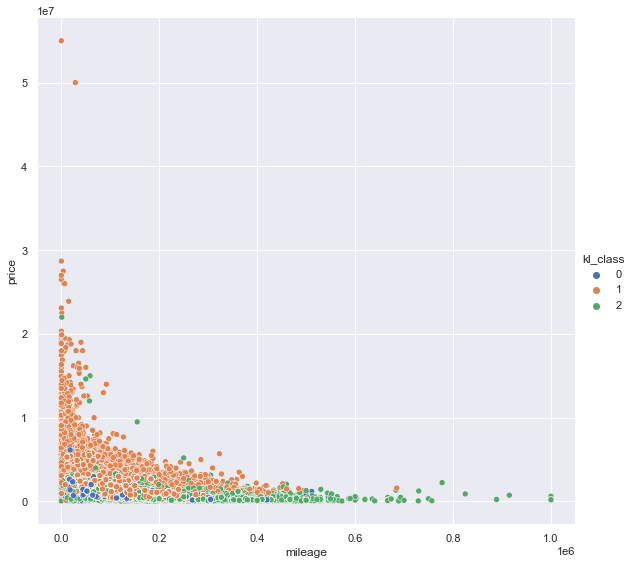

In [216]:
sns.relplot(
    x="mileage", y="price", hue="kl_class", data=df[df['sample'] == 1], height=8,
);

In [217]:
df[df['sample'] == 1].groupby('kl_class')['price'].agg(['count', 'median'])

,count,median
kl_class,,
0,11630,800000.0
1,20826,1799000.0
2,12732,500000.0


Поробую оставить этот кластер тоже

In [218]:
temp3 = df[["brand", "color", "modelDate"]] #   
temp3 = pd.get_dummies(temp3, columns=["brand", "color"])

temp_scaled3 = (temp3 - temp3.mean(axis=0)) / temp3.std(axis=0)
temp_scaled3.head()

,modelDate,brand_AUDI,brand_BMW,brand_HONDA,brand_INFINITI,brand_LEXUS,brand_MERCEDES,brand_MITSUBISHI,brand_NISSAN,brand_SKODA,...,color_коричневый,color_красный,color_оранжевый,color_пурпурный,color_розовый,color_серебристый,color_серый,color_синий,color_фиолетовый,color_чёрный
0,0.679589,-0.324558,-0.352567,-0.250381,-0.185749,-0.239731,-0.352791,-0.295861,-0.338721,3.408253,...,-0.218385,-0.207167,-0.058562,-0.091418,-0.018726,-0.336674,-0.376224,3.170495,-0.073225,-0.685582
1,1.229434,-0.324558,-0.352567,-0.250381,-0.185749,-0.239731,-0.352791,-0.295861,-0.338721,3.408253,...,-0.218385,-0.207167,-0.058562,-0.091418,-0.018726,-0.336674,-0.376224,-0.315404,-0.073225,1.458597
2,0.679589,-0.324558,-0.352567,-0.250381,-0.185749,-0.239731,-0.352791,-0.295861,-0.338721,3.408253,...,-0.218385,-0.207167,-0.058562,-0.091418,-0.018726,-0.336674,2.657957,-0.315404,-0.073225,-0.685582
3,0.679589,-0.324558,-0.352567,-0.250381,-0.185749,-0.239731,-0.352791,-0.295861,-0.338721,3.408253,...,4.579005,-0.207167,-0.058562,-0.091418,-0.018726,-0.336674,-0.376224,-0.315404,-0.073225,-0.685582
4,-0.007717,-0.324558,-0.352567,-0.250381,-0.185749,-0.239731,-0.352791,-0.295861,-0.338721,3.408253,...,-0.218385,-0.207167,-0.058562,-0.091418,-0.018726,-0.336674,-0.376224,-0.315404,-0.073225,-0.685582


In [219]:
kmeans = KMeans(n_clusters=4, n_init=15, random_state=RANDOM_SEED)
df["tem_kl3"] = kmeans.fit_predict(temp_scaled3)
df["tem_kl3"] = df["tem_kl3"].astype("category")

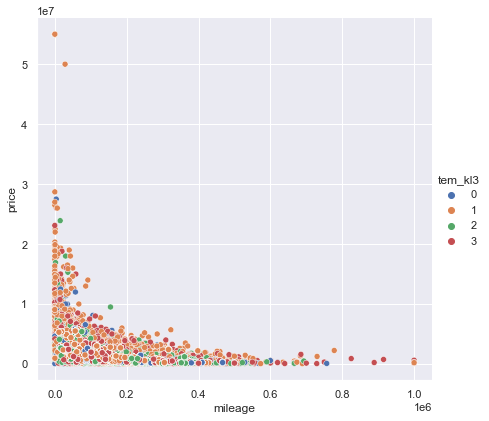

In [220]:
sns.relplot(
    x="mileage", y="price", hue="tem_kl3", data=df[df['sample'] == 1], height=6,
);

In [ ]:
# train.dtypes


## Модели

In [221]:
df.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'mileage_group', 'modelDate_group',
       'productionDate_group', 'unique_img', 'age', 'sample', 'price',
       'kl_brand_mil_age', 'kl_class', 'tem_kl3'],
      dtype='object')

In [222]:
droplidt = ['car_url', 'complectation_dict', 'description', 'equipment_dict', 'image', 'modelDate', 
'parsing_unixtime', 'priceCurrency', 'sell_id', 'super_gen', 'vehicleConfiguration', 'sample', 'tem_kl3',
'model_info', "name"]

После нескольких запусков моделей, решил оставить вот эти признаки которые в след ячейке  
Убрал несколько скоррелированных между собой, а также 5 признаков которые имеле очень низкое значение  
importance по рассчётам Random Forest

In [223]:
train_model = df[df['sample'] == 1][['bodyType', 'brand', 'color', 
       'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'model_name', 'productionDate',
       'vehicleTransmission', 'Владельцы',
       'Привод', 'unique_img', 'price',
       'kl_brand_mil_age', 'kl_class']].copy()

test_model = df[df['sample'] == 0][['bodyType', 'brand', 'color', 
       'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'model_name', 'productionDate',
       'vehicleTransmission', 'Владельцы',
       'Привод', 'unique_img', 'kl_brand_mil_age', 'kl_class']].copy()


# train_model = df[df['sample'] == 1][['bodyType', 'brand', 'color', 
#        'engineDisplacement', 'enginePower',
#        'fuelType', 'mileage', 'model_name', 'numberOfDoors', 'productionDate',
#        'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
#        'Привод', 'Руль', 'unique_img', 'price',
#        'kl_brand_mil_age', 'kl_class']].copy()

In [224]:
cat_features = list(train_model.loc[:, train_model.dtypes == object].columns)
cat_features

['bodyType',
 'brand',
 'color',
 'fuelType',
 'model_name',
 'vehicleTransmission',
 'Владельцы',
 'Привод']

In [225]:
num_features = train_model.drop('price', axis=1).loc[:, (train_model.dtypes == 'float64') | (train_model.dtypes == 'int64')].columns
num_features

Index(['engineDisplacement', 'enginePower', 'mileage', 'productionDate',
       'unique_img'],
      dtype='object')

In [226]:
cat_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_name','kl_brand_mil_age', 'kl_class',
       'vehicleTransmission', 'Владельцы', 'Привод']
num_features = ['enginePower', 'engineDisplacement','mileage', 'numberOfDoors', 
                'productionDate', 'sell_id', 'Владение', 'unique_img']

In [227]:
train_model['price'] = train_model['price'].apply(lambda x: x*0.013)

In [228]:
X = train_model.drop('price', axis=1)
y = train_model['price']

In [229]:
X.head()

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,model_name,productionDate,vehicleTransmission,Владельцы,Привод,unique_img,kl_brand_mil_age,kl_class
34686,внедорожник 5 дв.,VOLKSWAGEN,белый,2.0,170,бензин,92872.0,TIGUAN,2015.0,автоматическая,2 владельца,полный,1,0,0
34687,минивэн,VOLKSWAGEN,коричневый,2.0,180,дизель,177317.0,MULTIVAN,2011.0,роботизированная,3 или более,полный,1,0,0
34688,седан,VOLKSWAGEN,чёрный,1.8,152,бензин,84000.0,PASSAT_CC,2012.0,роботизированная,2 владельца,передний,1,0,0
34689,седан,VOLKSWAGEN,серый,1.4,150,бензин,17664.0,PASSAT,2019.0,роботизированная,1 владелец,передний,1,0,0
34690,седан,VOLKSWAGEN,белый,1.6,90,бензин,62807.0,POLO,2016.0,механическая,3 или более,передний,1,0,0


In [230]:
X.shape, test_model.shape

((45188, 15), (34686, 15))

In [231]:
var_rare = ['model_name']
X, test_model = encode_cat(X, y, test_model, var_rare, cat_features)

In [232]:
RFreg = RandomForestRegressor(n_estimators=1000, max_features=5) #211

In [233]:
RFreg.fit(X, y)

RandomForestRegressor(max_features=5, n_estimators=1000)

In [234]:
pred = np.round((RFreg.predict(test_model) * 77.03))
pred

array([ 679690., 1022862.,  928359., ...,  234698., 1460509., 1237462.])

In [235]:
pd.DataFrame({
    'feature': X.columns,
    'importance': RFreg.feature_importances_
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

,feature,importance
0,enginePower,0.263932
1,productionDate,0.245445
2,mileage,0.161602
3,engineDisplacement,0.106451
4,kl_class,0.041479
5,brand,0.039320
6,Привод,0.028765
7,bodyType,0.021681
8,model_name,0.021188
9,kl_brand_mil_age,0.019164


надо убрать:  
Владельцы	0.010237
13	unique_img	0.009027
14	color	0.008213
15	numberOfDoors	0.007672
16	Владение	0.007609
17	vendor	0.005152
18	ПТС	0.001183
19	Руль	0.000210

In [236]:
sample_submission['price'] = pred
sample_submission.to_csv('submissions/RF_1_4.csv', index=False)
sample_submission.head(10)
# 25.91599 25.99447  22.58681

,sell_id,price
0,1100575026,679690.0
1,1100549428,1022862.0
2,1100658222,928359.0
3,1100937408,797121.0
4,1101037972,834149.0
5,1100912634,893972.0
6,1101228730,740813.0
7,1100165896,416762.0
8,1100768262,2198688.0
9,1101218501,913917.0


Лучший результат в этой моделе я получил <b>MAPE = 22.58681</b>

### Catboost

In [238]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X, y,
         #cat_features=cat_features,
         eval_set=(X, y),
         verbose_eval=0,
         use_best_model=True,
         plot=True
         )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [239]:
pred = np.round((model.predict(test_model) * 77.03))
pred

array([ 625997.,  956076.,  959140., ...,  305931., 1534629., 1168626.])

In [240]:
sample_submission['price'] = pred
sample_submission.to_csv('submissions/CB_д.csv', index=False)
sample_submission.head(10)
# 25.99447
# 22.57763
# 23.03563
# 22.76951
# 22.49394

,sell_id,price
0,1100575026,625997.0
1,1100549428,956076.0
2,1100658222,959140.0
3,1100937408,718172.0
4,1101037972,806335.0
5,1100912634,893890.0
6,1101228730,780048.0
7,1100165896,446557.0
8,1100768262,2104380.0
9,1101218501,1009668.0


Лучший результат в этой моделе я получил <b>MAPE = 22.49394</b>

XGBoost

In [241]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.05, max_depth=12, alpha=1,
                          n_estimators=1000)
xgb_reg.fit(X, y)

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [242]:
xgb_red_pred = np.round((xgb_reg.predict(test_model) * 77.03))
# print_learn_report(start, y_test, xgb_red_pred)

In [243]:
sample_submission['price'] = xgb_red_pred
sample_submission.to_csv('submissions/xgb_l.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,754951.0
1,1100549428,1111964.0
2,1100658222,963204.0
3,1100937408,867730.0
4,1101037972,845236.0
5,1100912634,902798.0
6,1101228730,787445.0
7,1100165896,461318.0
8,1100768262,1923238.0
9,1101218501,1046098.0


In [ ]:
# 22.70459

Лучший результат в этой моделе я получил <b>MAPE = 22.70459</b>

### Ансамбль стэкинг

In [244]:
estimators=[('b_gbr', BaggingRegressor(GradientBoostingRegressor(random_state=RANDOM_SEED
                                                                ,n_estimators=800
                                                                ,min_samples_split=5
                                                                ,min_samples_leaf=4
                                                                ,max_features='sqrt'
                                                                ,max_depth=9)
                                        ,n_estimators=3
                                        ,n_jobs=1
                                        ,random_state=RANDOM_SEED))
            ,('xgb', xgb.XGBRegressor(objective='reg:squarederror'
                                      ,colsample_bytree=0.5
                                      ,learning_rate=0.05
                                      ,max_depth=12
                                      ,alpha=1
                                      ,n_estimators=1000))]

st_ensemble = StackingRegressor(estimators=estimators
                                ,final_estimator = CatBoostRegressor(iterations = 5000
                                                                     ,random_seed = RANDOM_SEED
                                                                     ,eval_metric='MAPE'
                                                                     ,custom_metric=['R2', 'MAE']
                                                                     ,silent=True
                                                                     ,learning_rate=0.13
                                                                     ,depth=12
                                                                     ,l2_leaf_reg=8
                                                                     ,random_strength=0.3))

    


In [245]:
st_ensemble.fit(X, y)

StackingRegressor(estimators=[('b_gbr',
                               BaggingRegressor(base_estimator=GradientBoostingRegressor(max_depth=9,
                                                                                         max_features='sqrt',
                                                                                         min_samples_leaf=4,
                                                                                         min_samples_split=5,
                                                                                         n_estimators=800,
                                                                                         random_state=42),
                                                n_estimators=3, n_jobs=1,
                                                random_state=42)),
                              ('xgb',
                               XGBRegressor(alpha=1, base_score=None,
                                            booster=None,
        

In [246]:
predict_ensemble = np.round((st_ensemble.predict(test_model) * 77.03))

In [247]:
sample_submission['price'] = predict_ensemble
sample_submission.to_csv('submissions/ans.csv', index=False)
sample_submission.head(10)
#22.67197

,sell_id,price
0,1100575026,732451.0
1,1100549428,1055077.0
2,1100658222,869167.0
3,1100937408,858747.0
4,1101037972,873089.0
5,1100912634,861395.0
6,1101228730,759856.0
7,1100165896,451040.0
8,1100768262,1912067.0
9,1101218501,1048220.0


Лучший результат в этой моделе я получил <b>MAPE = 22.67197</b>

## Выводы

В итоге лучшая модель окзалась Catboost, хотя и Random Forest тоже хорошо справился с задачей, если бы было больше времени я думаю можно было бы улучшить результат с помощью алгоритма Random Forest.
Ни одна из моделей не дала результат значение МАРЕ ниже 20, скорее всего для обучения недодстаточно данных.  
Чтобы улучшить результаты стоит попробовать:
+ собрать больше данных
+ более тщательно проверить взаимосвязи признаков и поробовать создать больше новых признаков
+ для каждого алгоритма оптимизировать параметры  
  
Все алгоритмы кроме стэкинга работали меньше 2 минут